In [2]:
import numpy as np # linear algebra
from scipy import signal
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import time
%matplotlib inline
import tensorflow
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPool1D, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from sklearn.model_selection import train_test_split
import keras.backend as K

Using TensorFlow backend.


In [11]:
t=time.time()
X=np.loadtxt('X.csv',delimiter=',')
Y=np.loadtxt('Y.csv',delimiter=',')
print(time.time()-t)

178.0547399520874


In [12]:
print(np.sum(X<0)/1000) #check for faulty data

0.0


In [13]:
X=np.reshape(X,(-1,1000,4))

eps=1e-15

X=X*(X>0)
X=np.log10(X+eps)

#Normalising X
x_mean=np.mean(np.mean(X,axis=0),axis=0)
x_std=np.std(np.std(X,axis=0),axis=0)
print(x_mean,x_std)
for i in range(4):
    X[:,:,i]=(X[:,:,i]-x_mean[i])/x_std[i]
    
    
Y=np.log10(Y*1e20)

#Min_Max Scaling of Y
y_min=np.min(Y)
Y=Y-y_min
y_max=np.max(Y)
Y=Y/y_max

[0.75381023 3.84472655 2.35869692 1.51397456] [0.21760315 0.19150221 0.39511973 0.68657963]


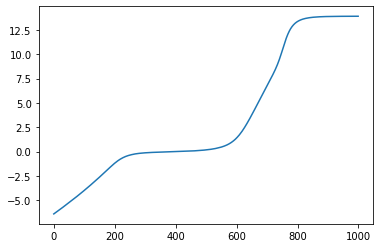

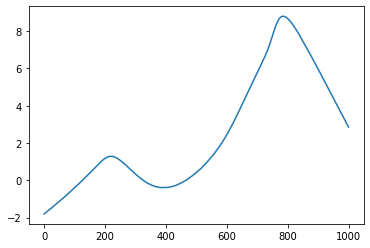

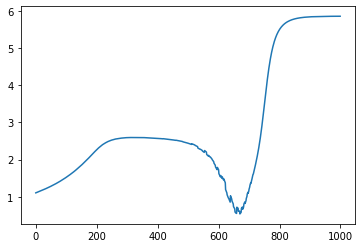

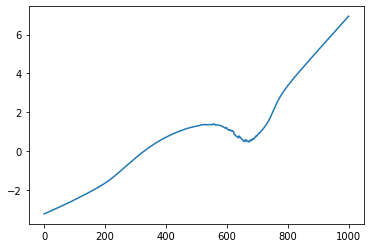

(7996, 1000, 4) (7996, 500) (1999, 1000, 4) (1999, 500)


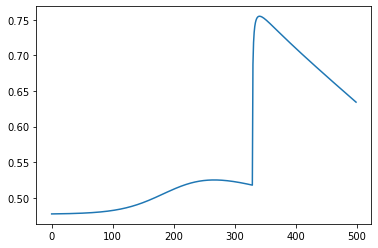

In [14]:
plt.plot(np.transpose(X[0,:,0]))
plt.show()
plt.plot(np.transpose(X[0,:,1]))
plt.show()
plt.plot(np.transpose(X[0,:,2]))
plt.show()
plt.plot(np.transpose(X[0,:,3]))
plt.show()

plt.plot(np.transpose(Y[0,:]))

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

print(np.shape(x_train),np.shape(y_train),np.shape(x_test),np.shape(y_test))

In [15]:
#Data Analysis
'''print(np.shape(X))
X = np.reshape(np.transpose(X,(0,2,1)),(-1,1000*3))
X=(X-np.mean(X,axis=0))/np.std(X,axis=0)
X_=np.matrix.transpose(X)

lambd,W=np.linalg.eig(np.matmul(X_,X))

plt.plot(np.log(lambd))
plt.show()

Z=np.abs(np.matmul(X,W[:,:3]))
print(np.shape(Z))

for i in range(4):
    plt.scatter(Z[:,0],Z[:,1], c=Y[:,i], cmap="coolwarm")
    plt.show()
'''

'print(np.shape(X))\nX = np.reshape(np.transpose(X,(0,2,1)),(-1,1000*3))\nX=(X-np.mean(X,axis=0))/np.std(X,axis=0)\nX_=np.matrix.transpose(X)\n\nlambd,W=np.linalg.eig(np.matmul(X_,X))\n\nplt.plot(np.log(lambd))\nplt.show()\n\nZ=np.abs(np.matmul(X,W[:,:3]))\nprint(np.shape(Z))\n\nfor i in range(4):\n    plt.scatter(Z[:,0],Z[:,1], c=Y[:,i], cmap="coolwarm")\n    plt.show()\n'

In [46]:
model = Sequential()

model.add(Flatten(input_shape=(1000,4)))
model.add(Dense(2000, activation='linear'))
model.add(LeakyReLU(alpha=.1))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(4000, activation='linear'))
model.add(LeakyReLU(alpha=.1))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(2000, activation='linear'))
model.add(LeakyReLU(alpha=.1))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(4000, activation='linear'))
model.add(LeakyReLU(alpha=.1))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(2000, activation='linear'))
model.add(LeakyReLU(alpha=.1))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(500, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 4000)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 2000)              8002000   
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 2000)              0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 2000)              8000      
_________________________________________________________________
dropout_4 (Dropout)          (None, 2000)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 4000)              8004000   
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 4000)              0         
__________

In [47]:
#import tensorflow as tf
def loss_func(y_true,y_pred):
    lambd = 0.01 #Regularisation parameter
    return K.mean(K.square(y_pred - y_true), axis=-1) #+ lambd*K.sum(K.square(y_pred[:,1:]-y_pred[:,:-1]))

In [48]:
model.compile(loss='mean_squared_error', optimizer = Adam(lr=1e-4), metrics=["accuracy"]) #binary_crossentropy #loss_func

annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

hist = model.fit(x=x_train, y=y_train, batch_size=1024,
                           epochs=20, #Increase this when not on Kaggle kernel
                           verbose=2,  #1 for ETA, 0 for silent
                           validation_data=(x_test, y_test), #For speed
                           callbacks=[annealer])

Train on 7996 samples, validate on 1999 samples
Epoch 1/20
 - 26s - loss: 0.0375 - acc: 0.0040 - val_loss: 0.3027 - val_acc: 0.0070
Epoch 2/20
 - 20s - loss: 0.0176 - acc: 0.0065 - val_loss: 0.0722 - val_acc: 0.0040
Epoch 3/20
 - 20s - loss: 0.0109 - acc: 0.0055 - val_loss: 0.0203 - val_acc: 0.0080
Epoch 4/20
 - 20s - loss: 0.0088 - acc: 0.0088 - val_loss: 0.0154 - val_acc: 0.0060
Epoch 5/20
 - 20s - loss: 0.0078 - acc: 0.0094 - val_loss: 0.0128 - val_acc: 0.0110
Epoch 6/20
 - 20s - loss: 0.0104 - acc: 0.0090 - val_loss: 0.1089 - val_acc: 0.0040
Epoch 7/20
 - 20s - loss: 0.0110 - acc: 0.0099 - val_loss: 0.0525 - val_acc: 0.0070
Epoch 8/20
 - 21s - loss: 0.0076 - acc: 0.0070 - val_loss: 0.0061 - val_acc: 0.0090
Epoch 9/20
 - 21s - loss: 0.0060 - acc: 0.0095 - val_loss: 0.0058 - val_acc: 0.0085
Epoch 10/20
 - 21s - loss: 0.0071 - acc: 0.0096 - val_loss: 0.0475 - val_acc: 0.0070
Epoch 11/20
 - 21s - loss: 0.0063 - acc: 0.0089 - val_loss: 0.0073 - val_acc: 0.0120
Epoch 12/20
 - 21s - loss:

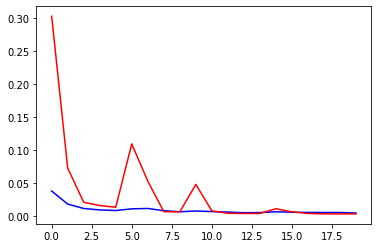

In [49]:
plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.show()

In [50]:
model.evaluate(x_test, y_test)

1999/1999 [==============================] - 2s 821us/step


[0.002701637860650328, 0.014007003501750876]

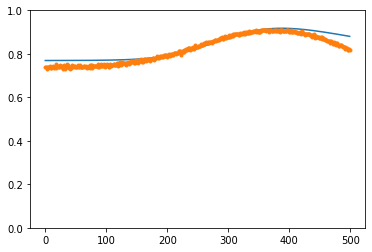

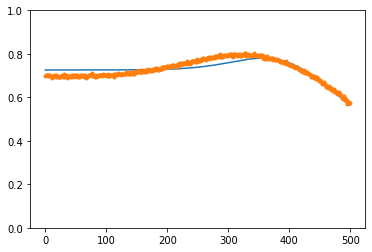

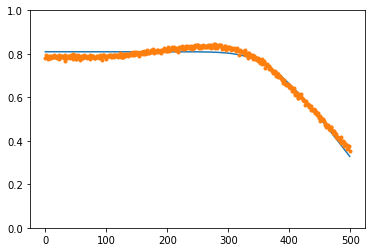

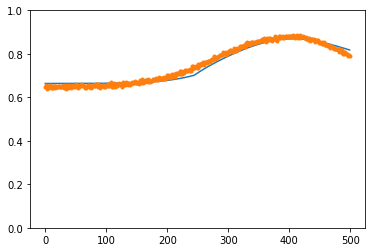

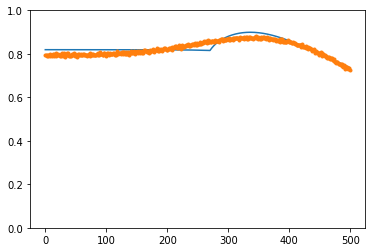

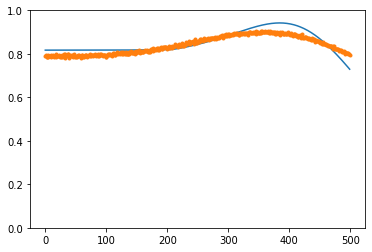

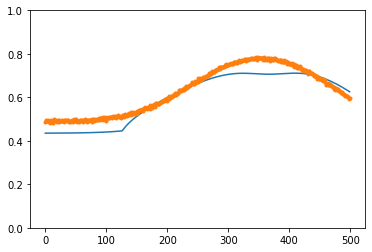

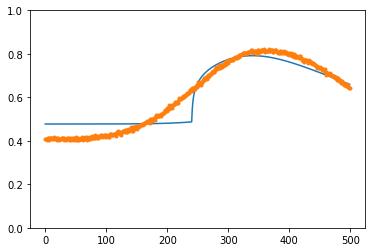

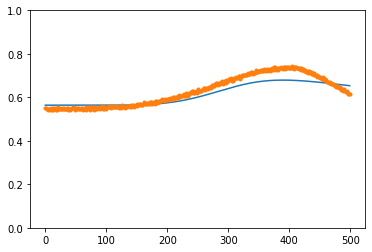

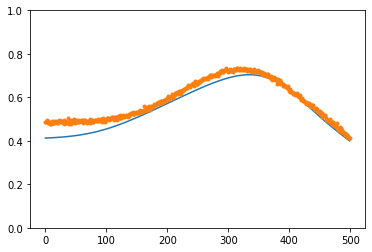

In [51]:
import scipy.ndimage.filters as sp
y_hat=model.predict(x_train)
np.shape(y_hat)
for i in range(10):
    plt.plot(y_train[i,:])
    plt.plot(y_hat[i,:],'.')
    plt.ylim((0,1))
    plt.show()

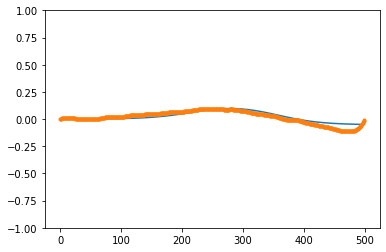

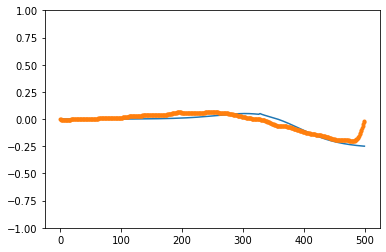

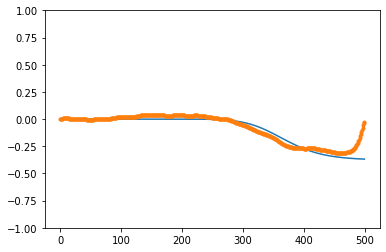

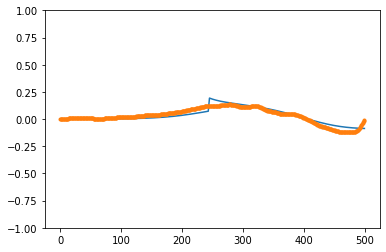

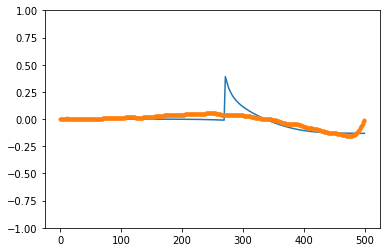

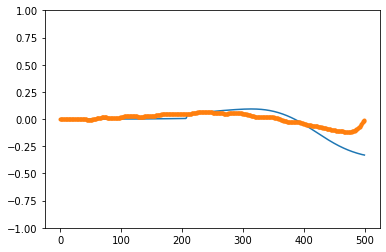

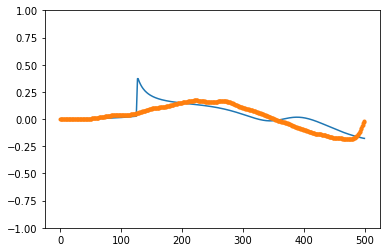

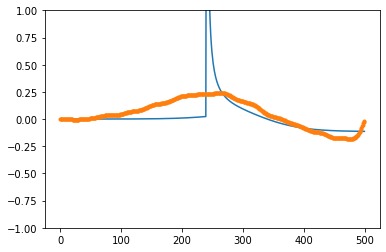

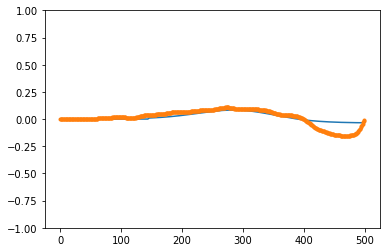

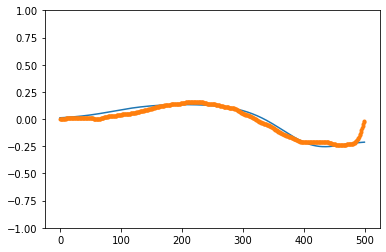

In [52]:
y_hat=sp.gaussian_filter1d(model.predict(x_train),10)
for i in range(10):
    plt.plot(np.gradient(y_train[i,:])*100)
    plt.plot(np.gradient(y_hat[i,:])*100,'.')
    plt.ylim((-1,1))
    plt.show()

['Bolsig', 'Input', 'Output', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'ex', 'surge_exp', 'surge_pwr']
|(1000, 4)


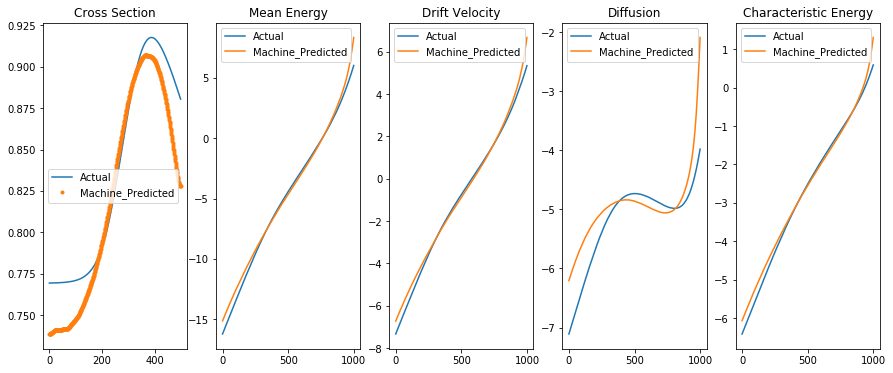

|(1000, 4)


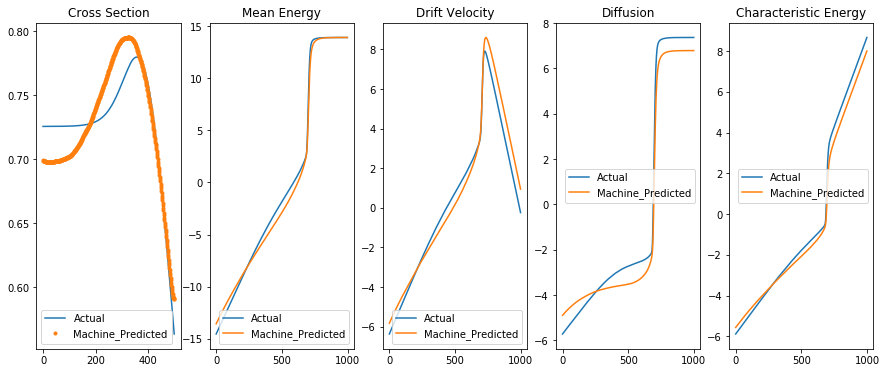

|(1000, 4)


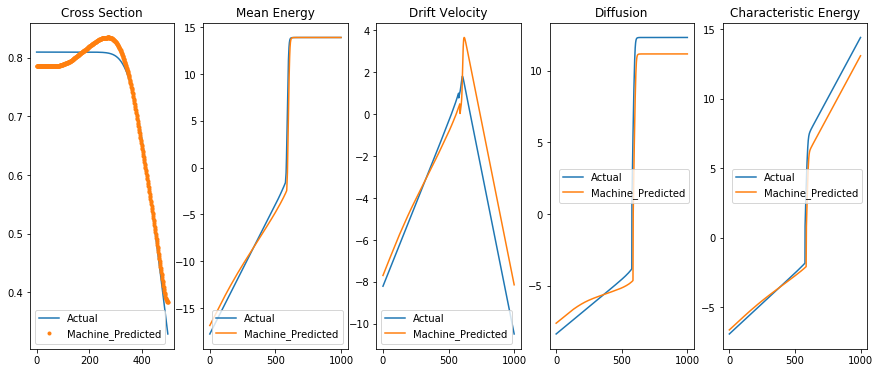

|(1000, 4)


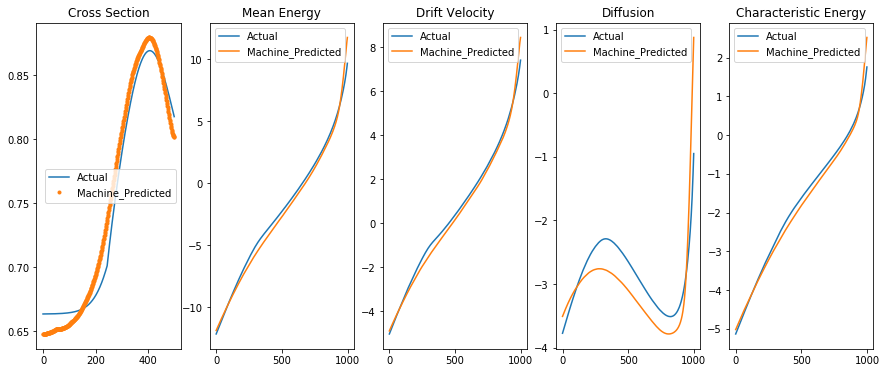

|(1000, 4)


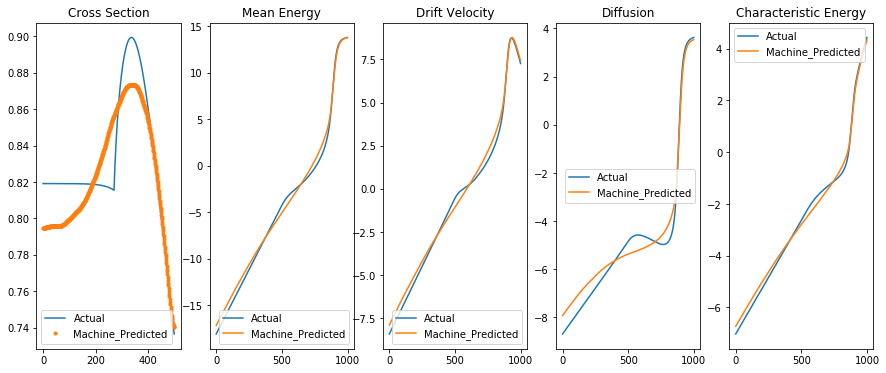

|(1000, 4)


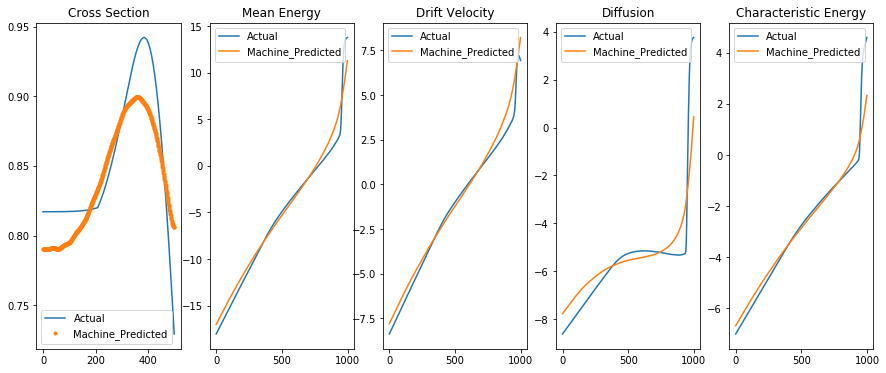

|(1000, 4)


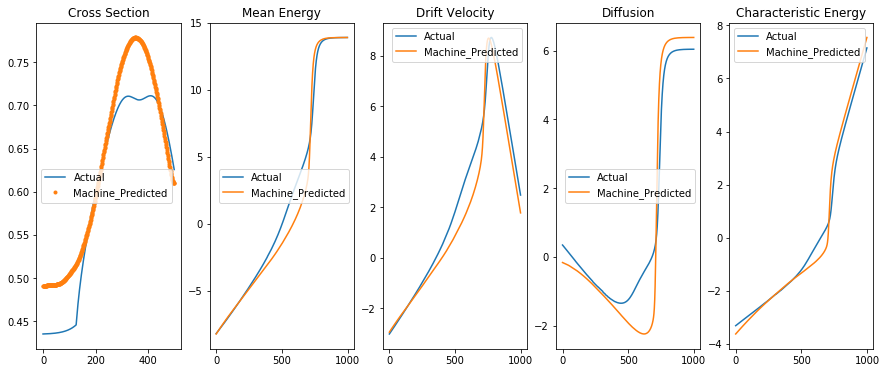

|(1000, 4)


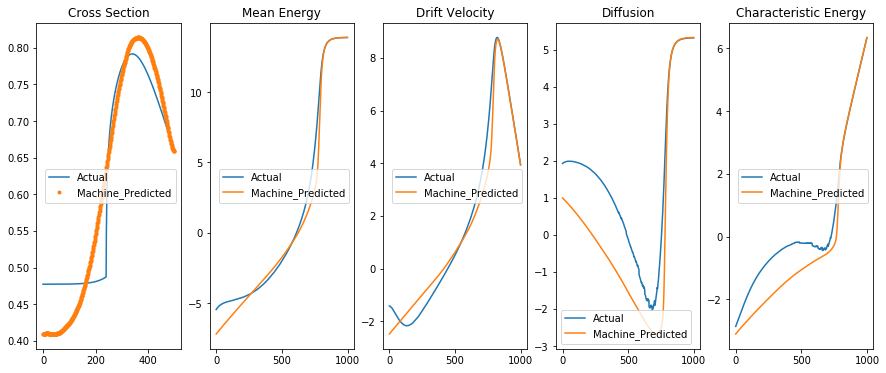

|(1000, 4)


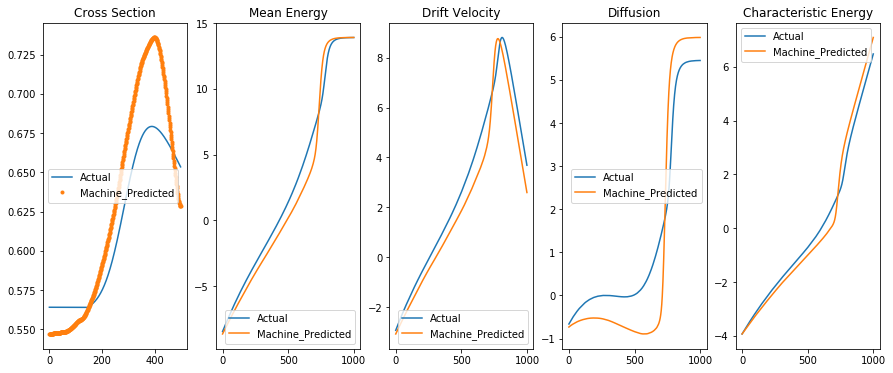

|(1000, 4)


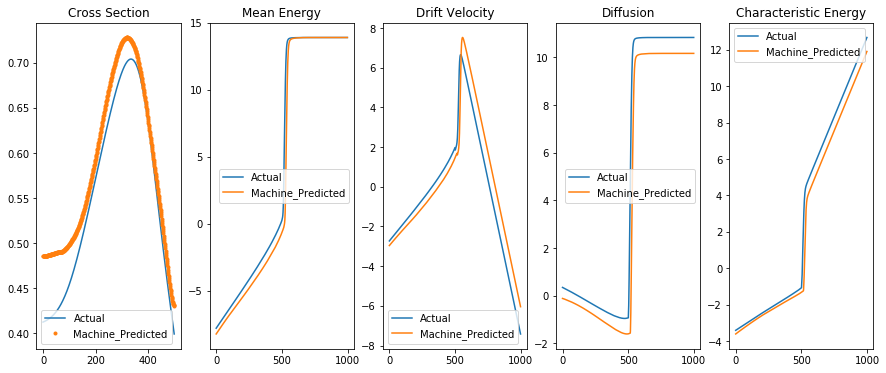

|(1000, 4)


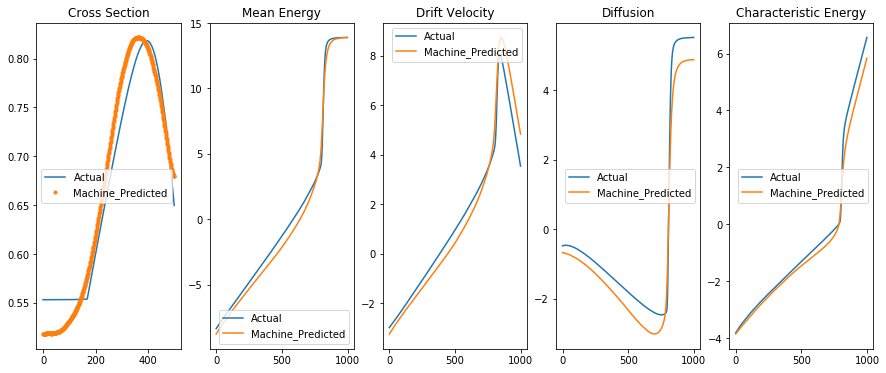

|(1000, 4)


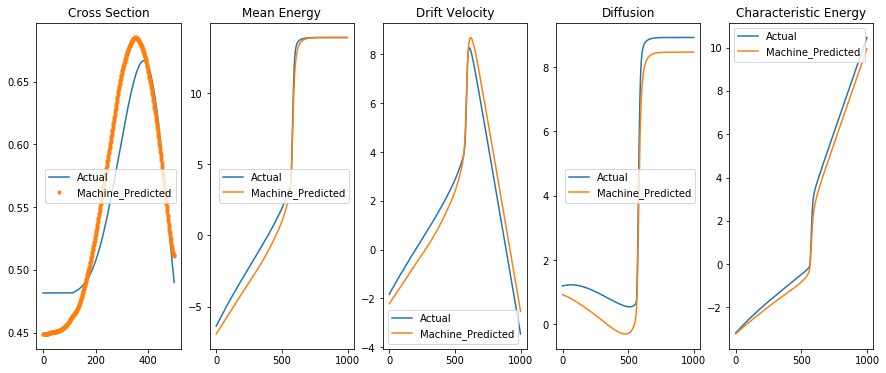

|(1000, 4)


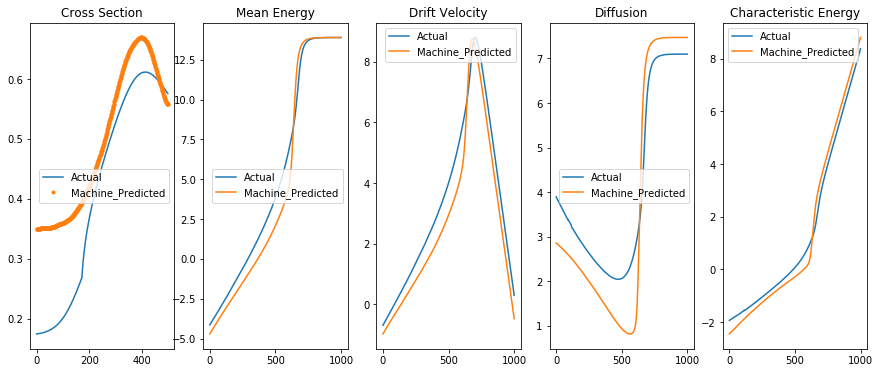

|(1000, 4)


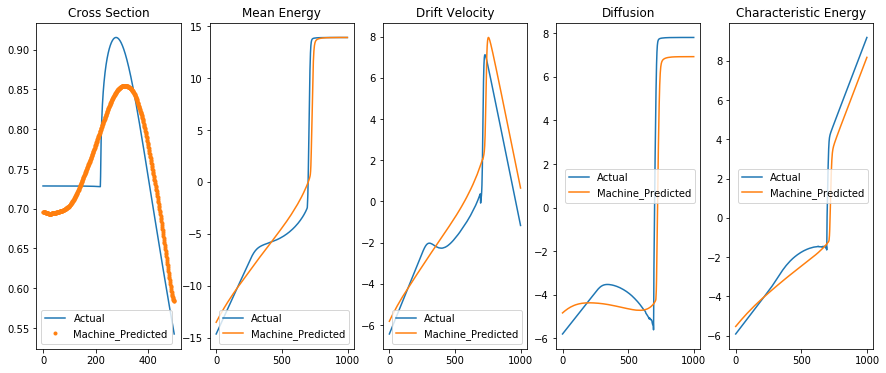

|(1000, 4)


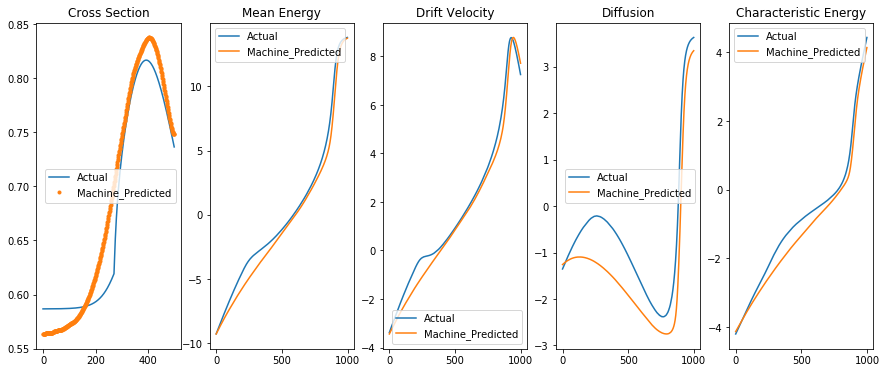

|(1000, 4)


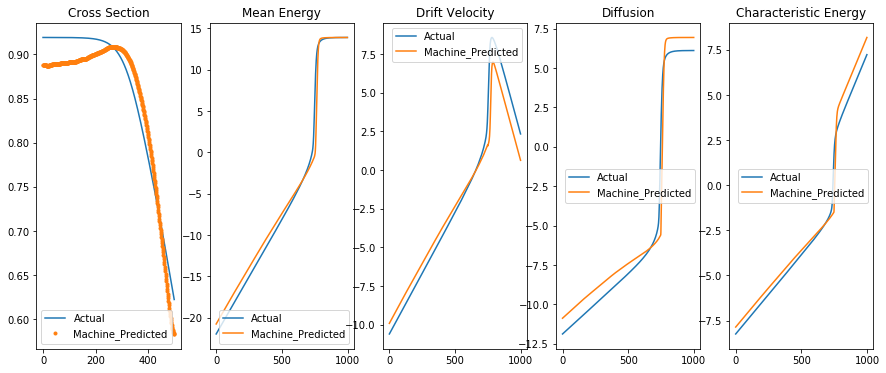

|(1000, 4)


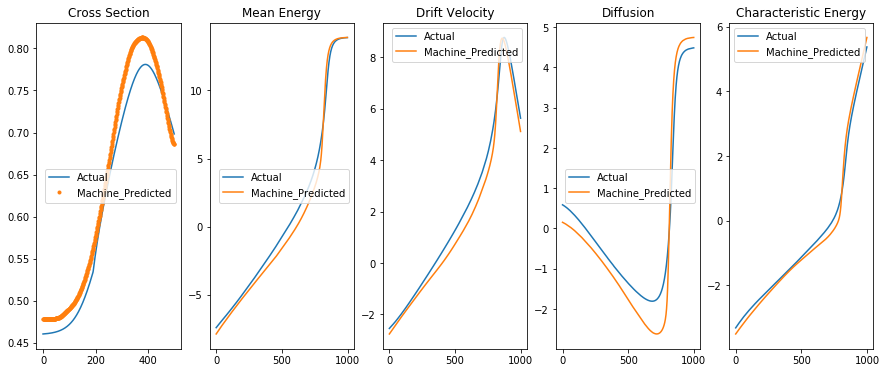

|(1000, 4)


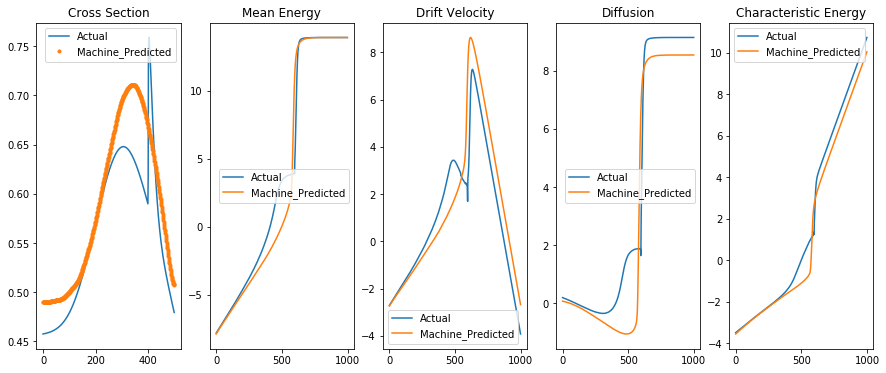

|(1000, 4)


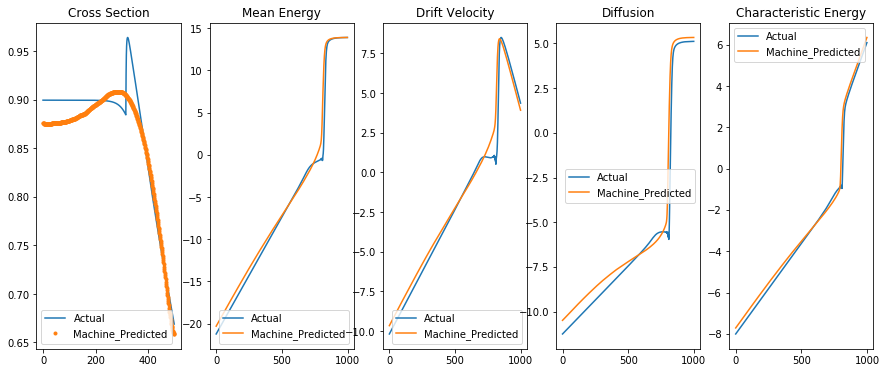

|(1000, 4)


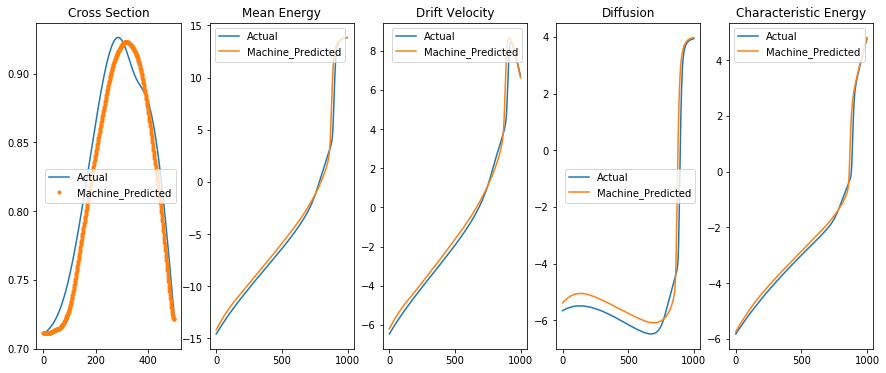

|(1000, 4)


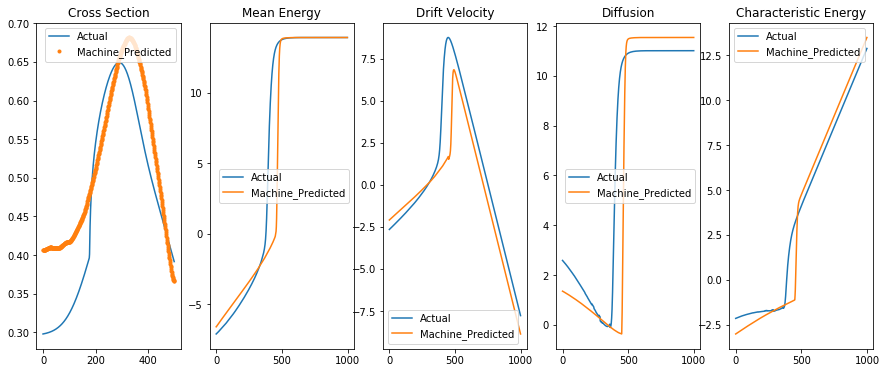

|(1000, 4)


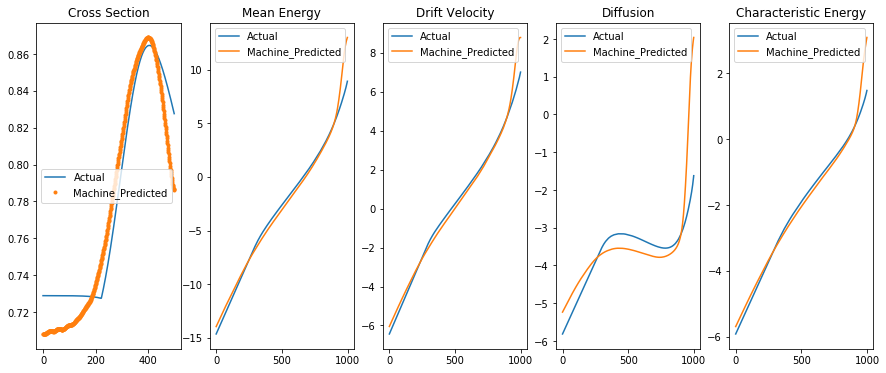

|(1000, 4)


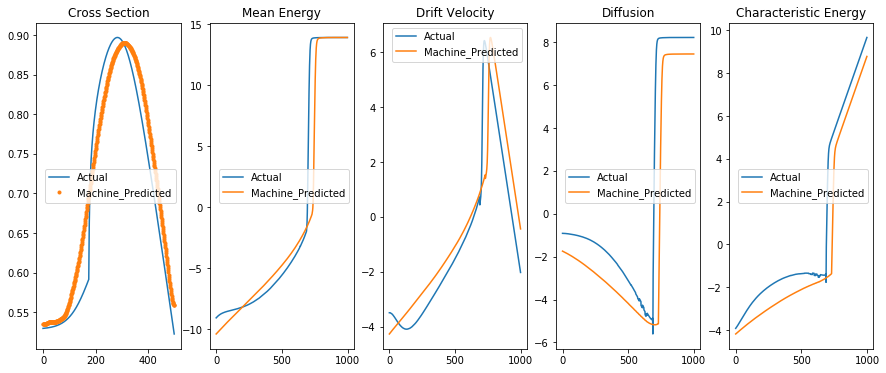

|(1000, 4)


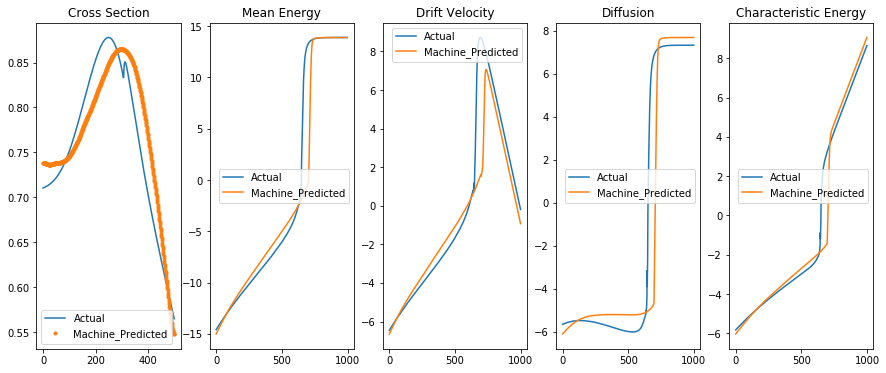

|(1000, 4)


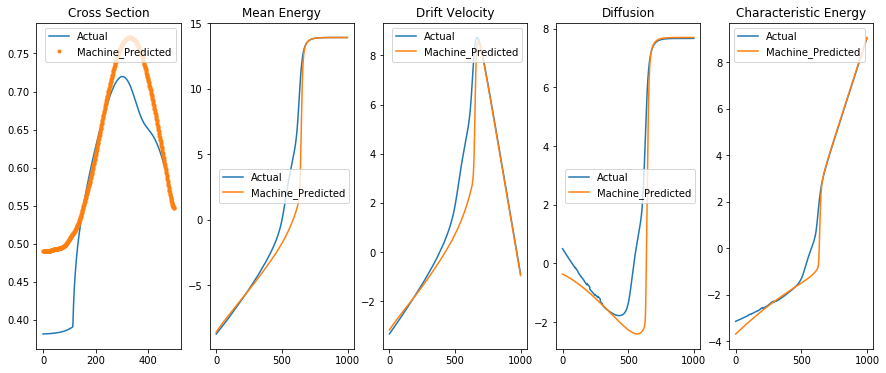

|(1000, 4)


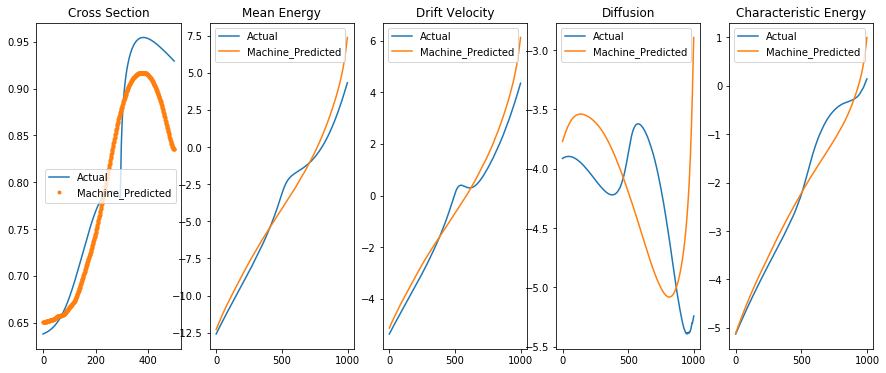

|(1000, 4)


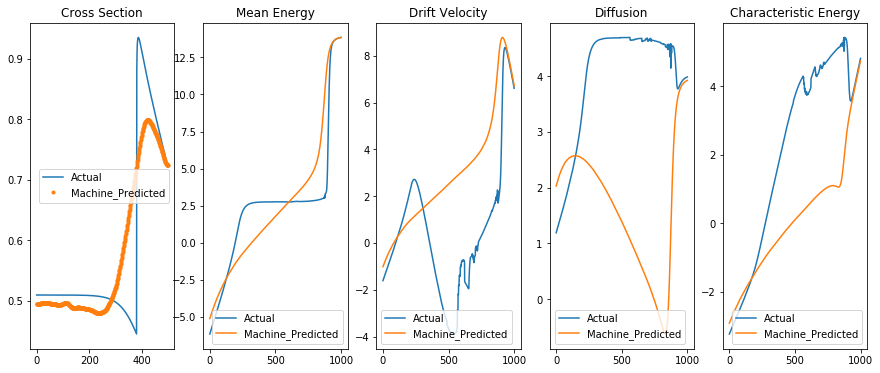

|(1000, 4)


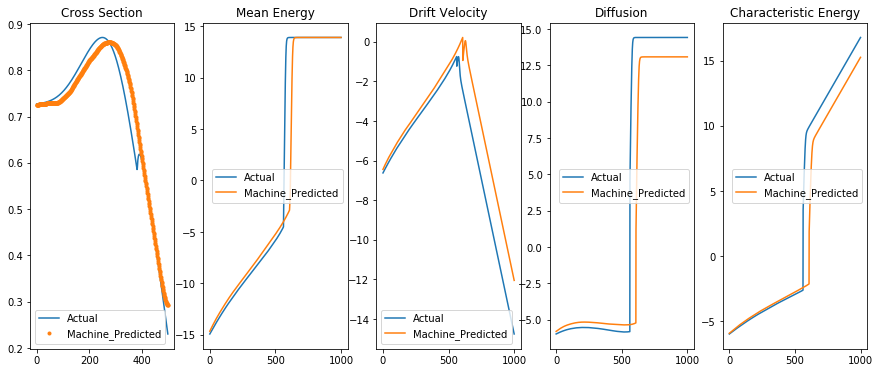

|(1000, 4)


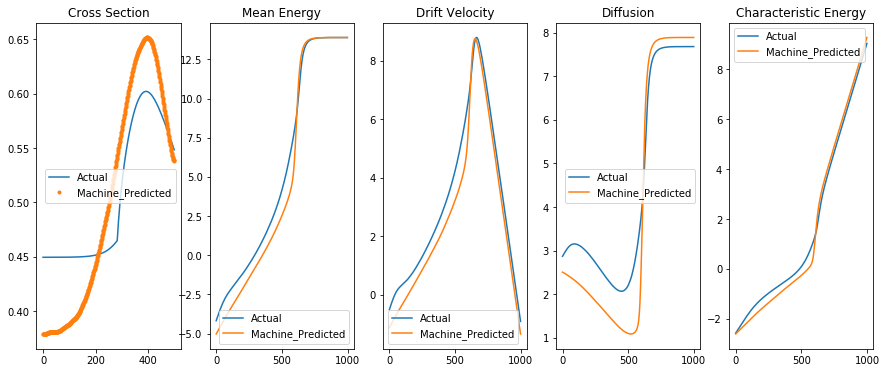

|(1000, 4)


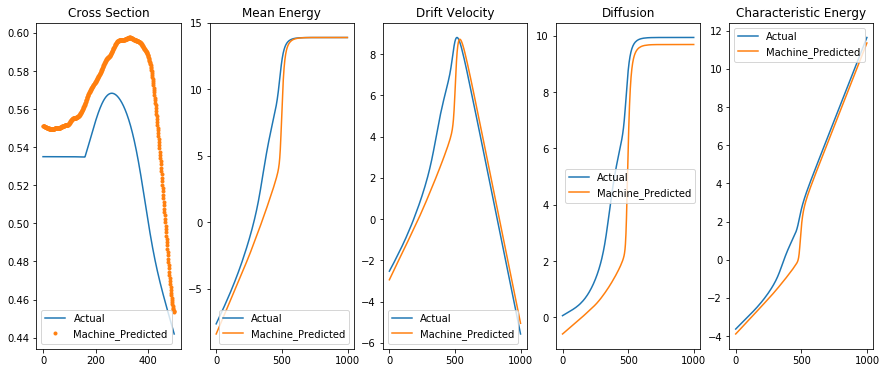

|(1000, 4)


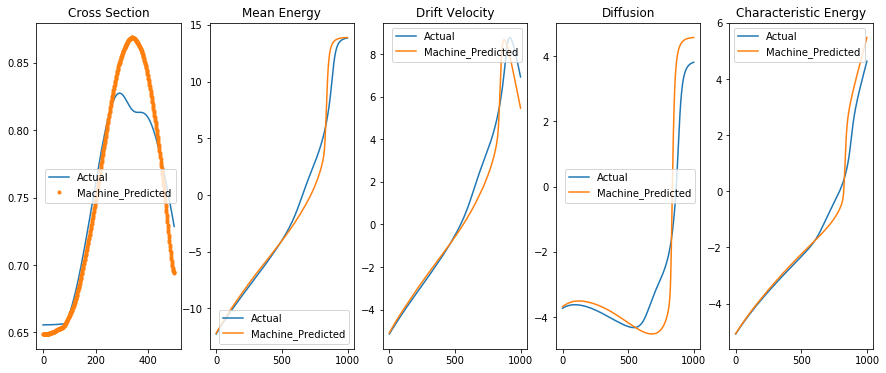

|(1000, 4)


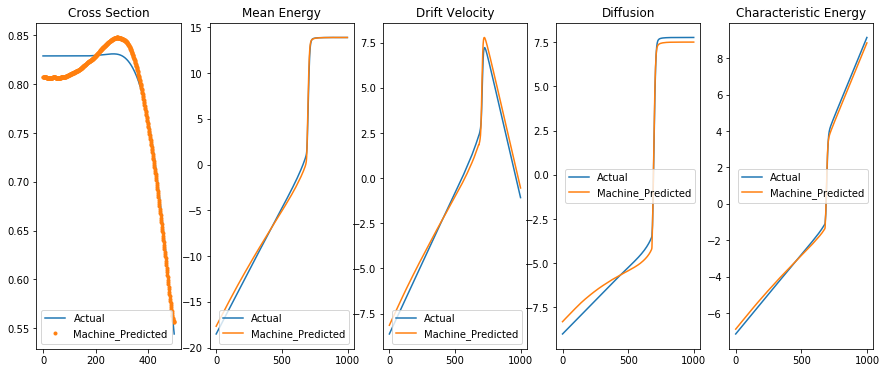

|(1000, 4)


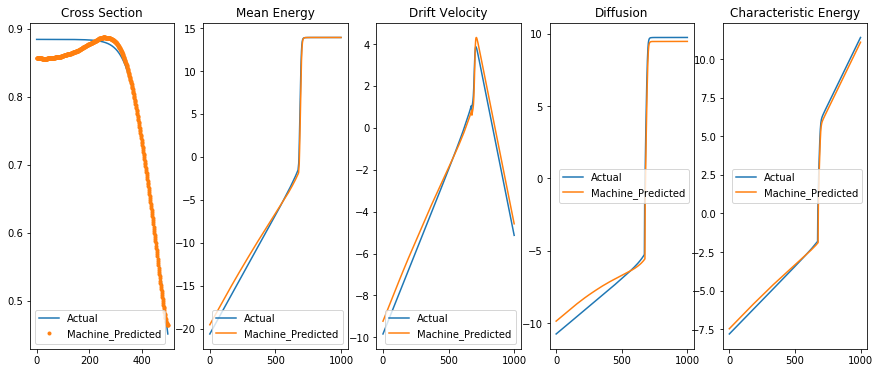

|(1000, 4)


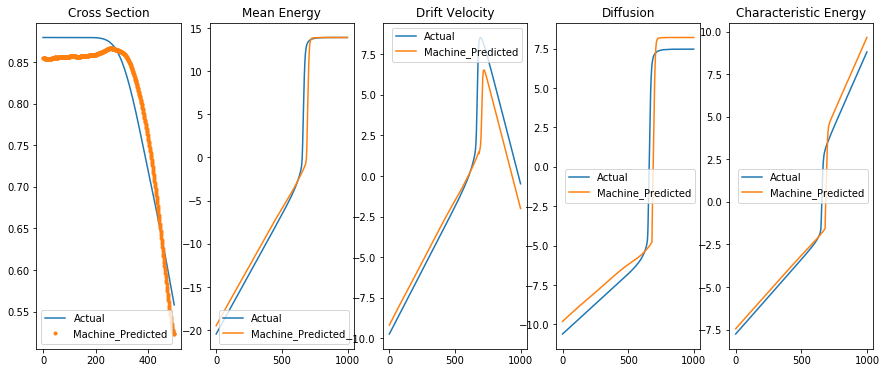

|(1000, 4)


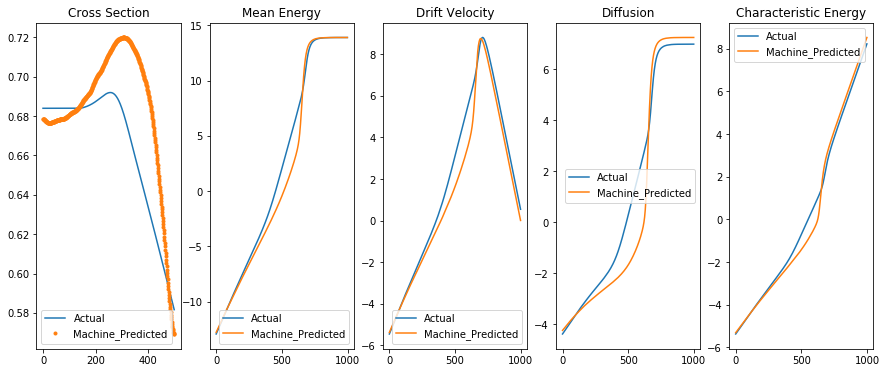

|(1000, 4)


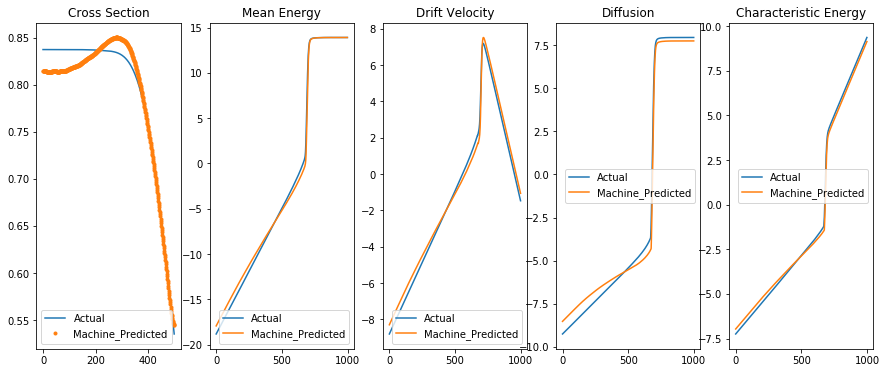

|(1000, 4)


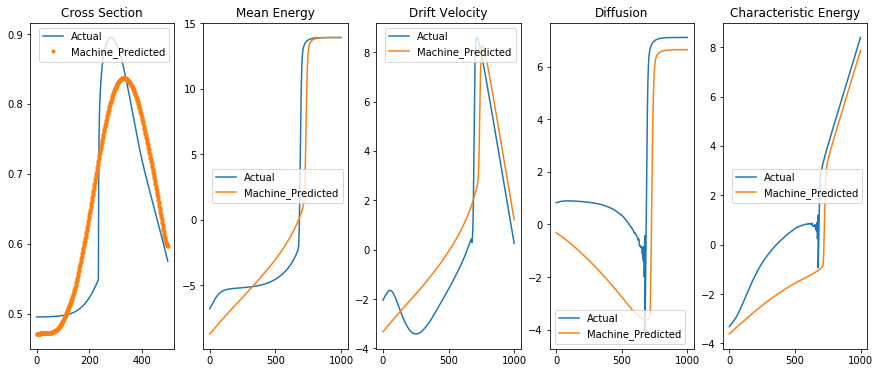

|(1000, 4)


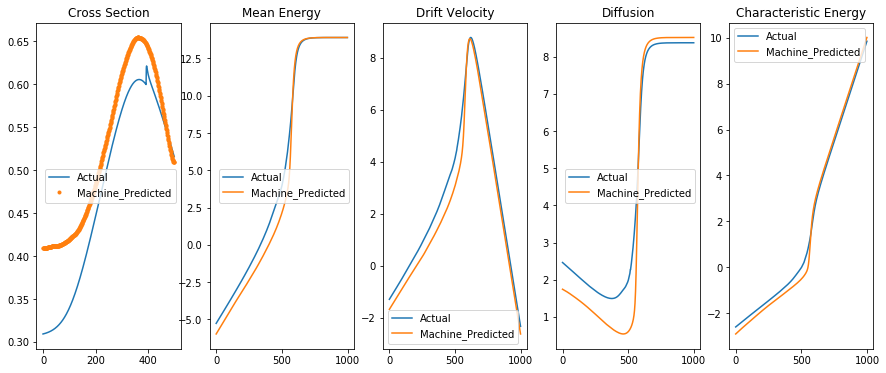

|(1000, 4)


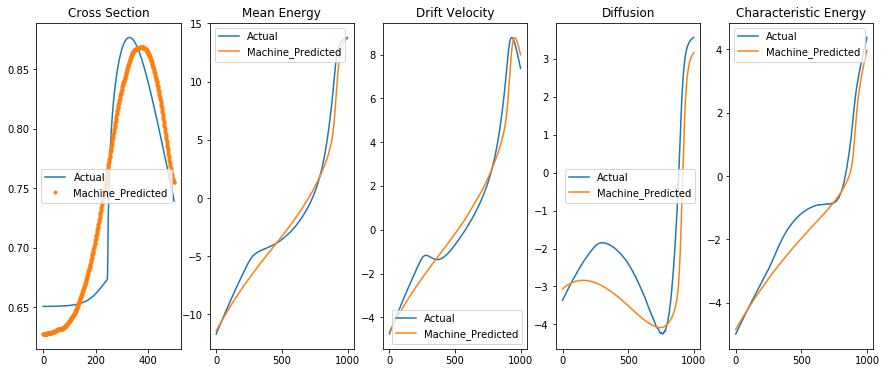

|(1000, 4)


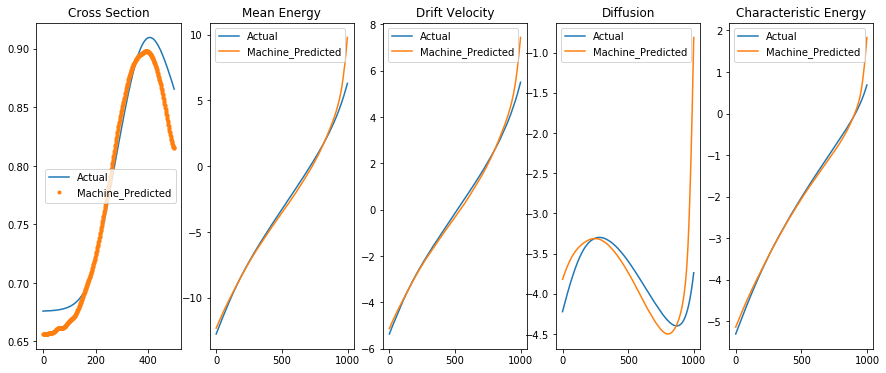

|(1000, 4)


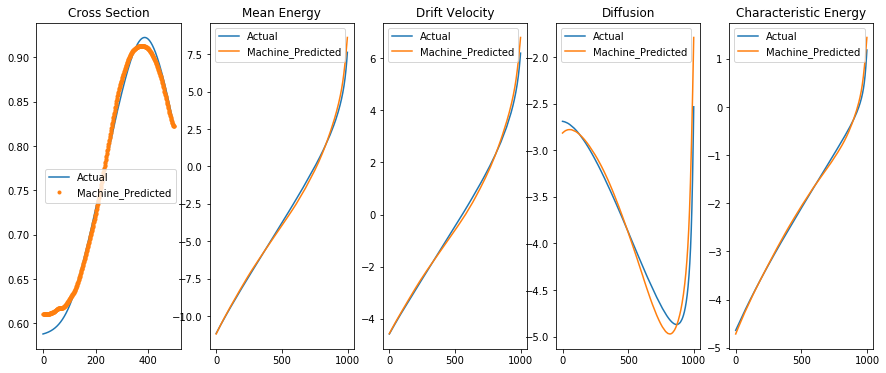

|(1000, 4)


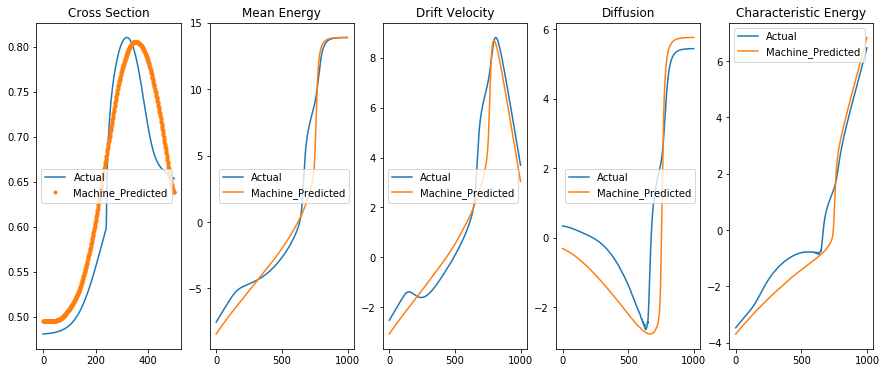

|(1000, 4)


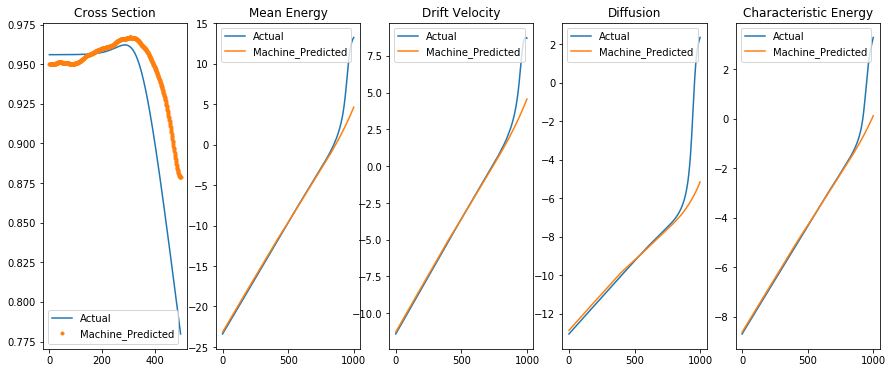

|(1000, 4)


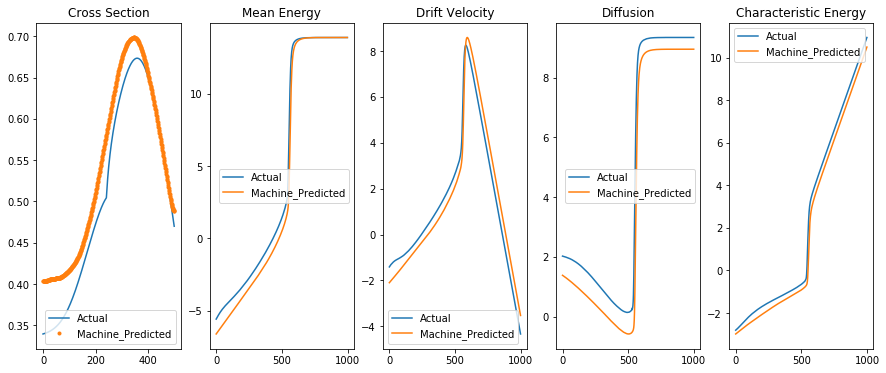

|(1000, 4)


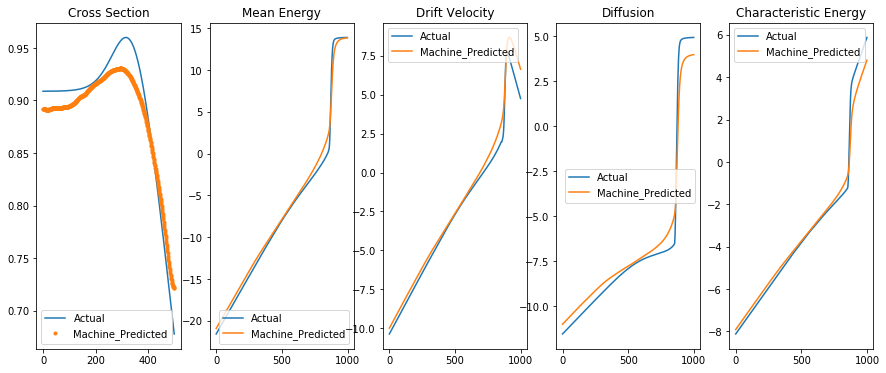

|(1000, 4)


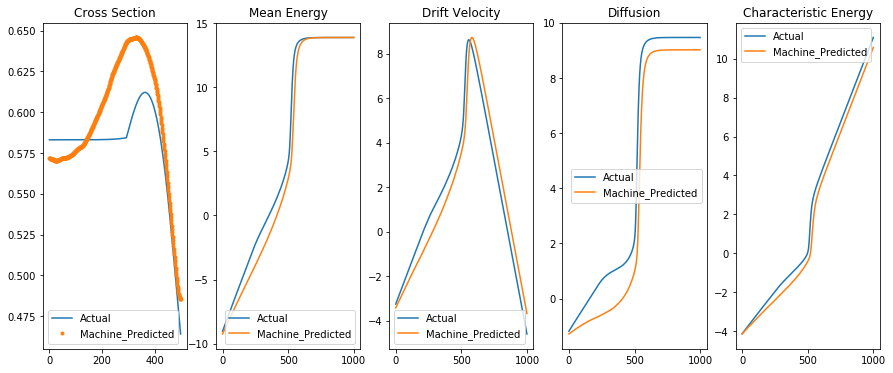

|(1000, 4)


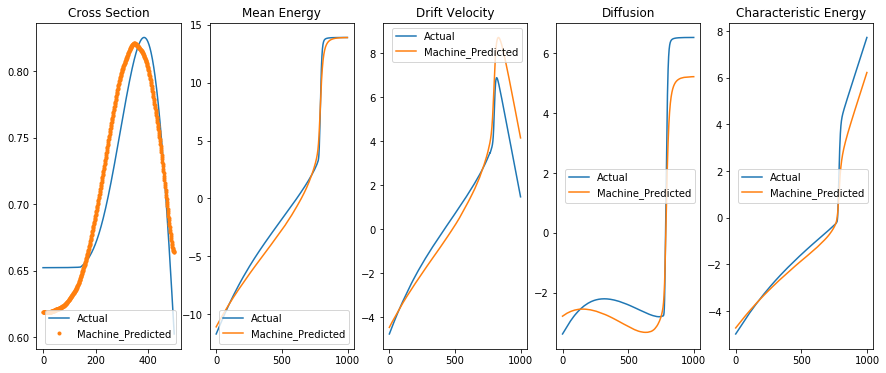

|(1000, 4)


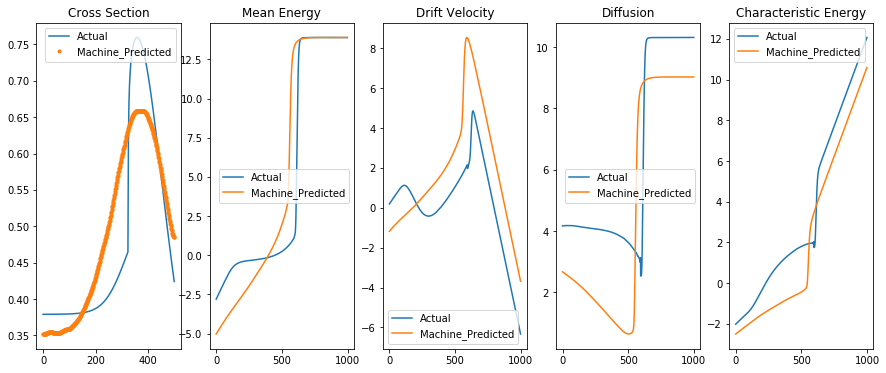

|(1000, 4)


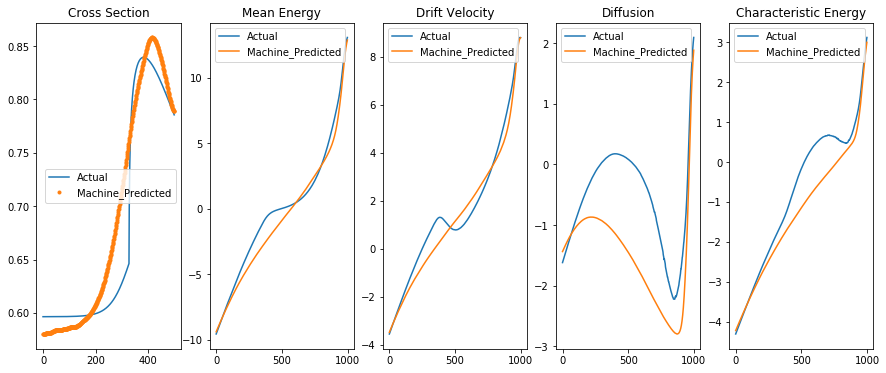

|(1000, 4)


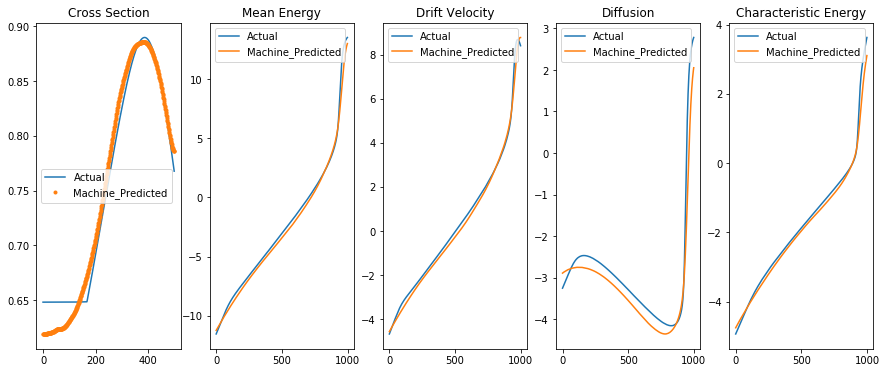

|(1000, 4)


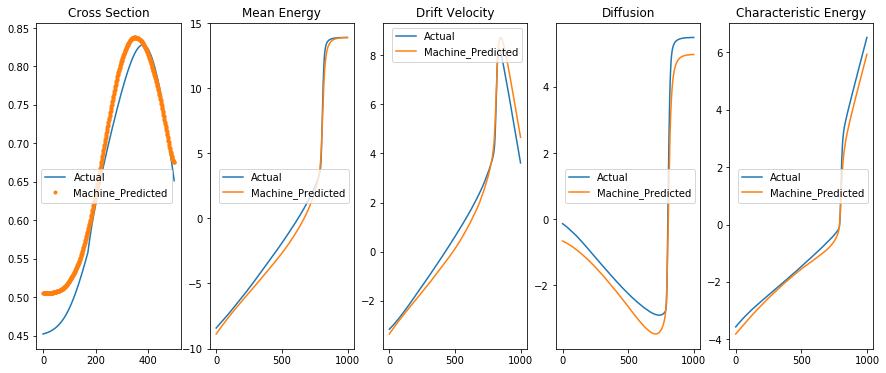

|(1000, 4)


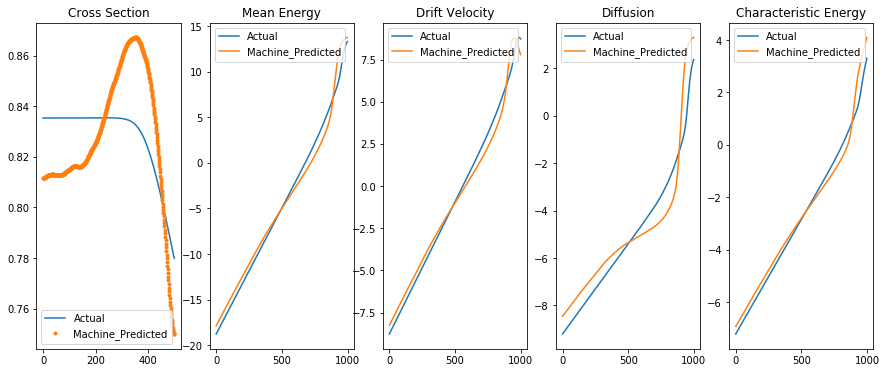

|(1000, 4)


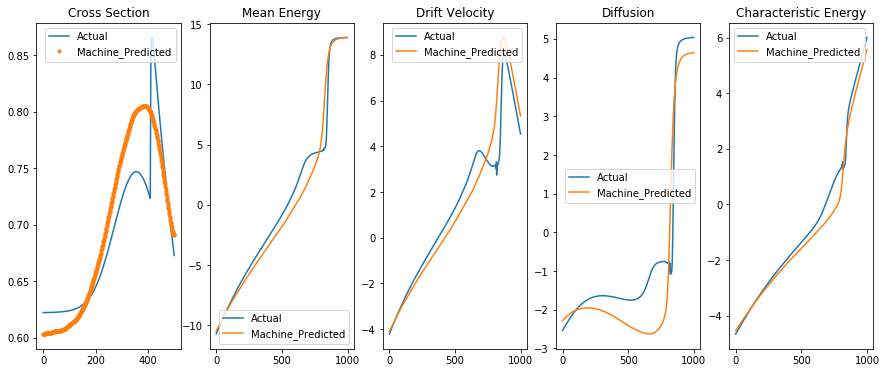

|(1000, 4)


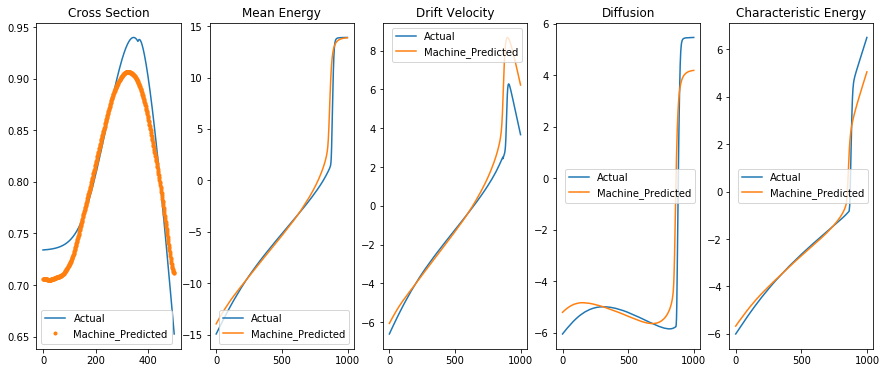

|(1000, 4)


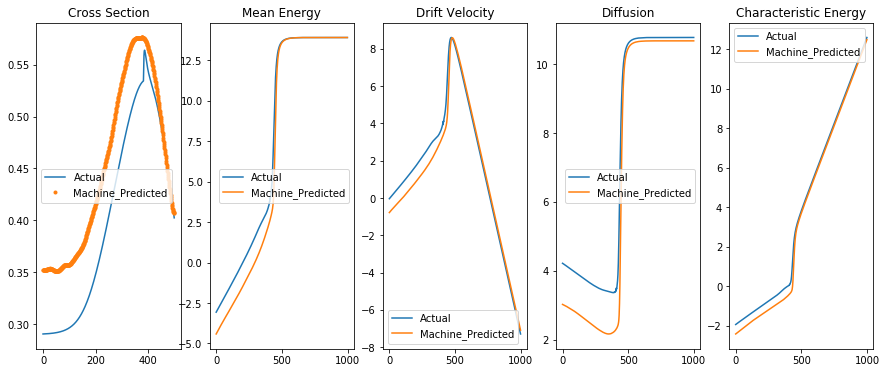

|(1000, 4)


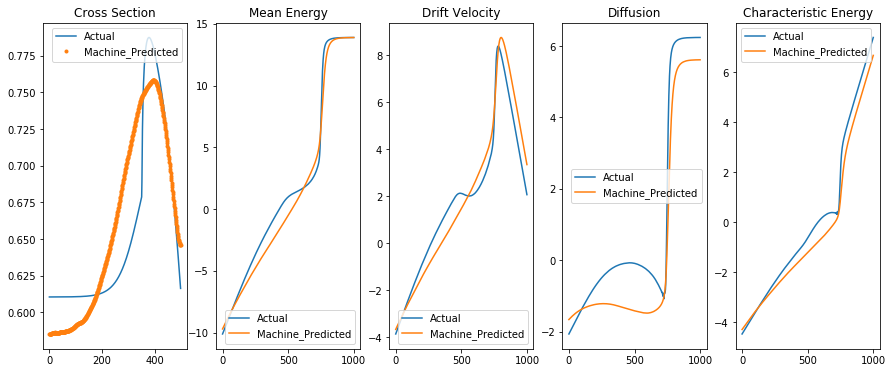

|(1000, 4)


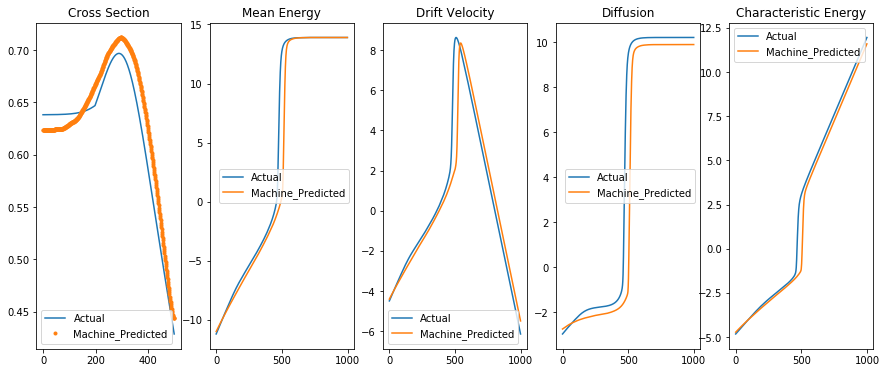

|(1000, 4)


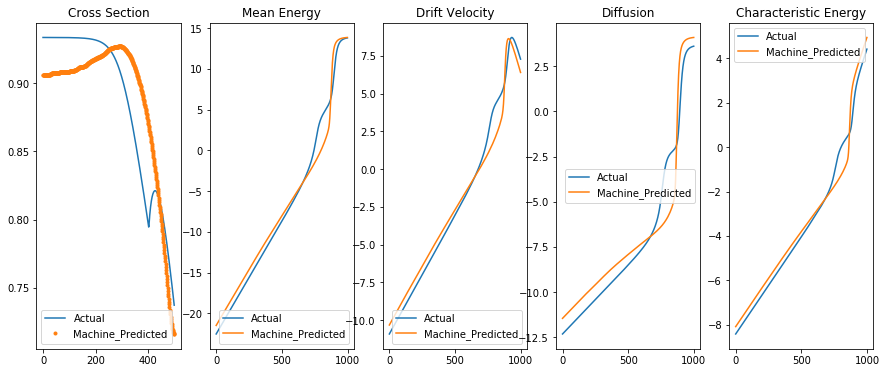

|(1000, 4)


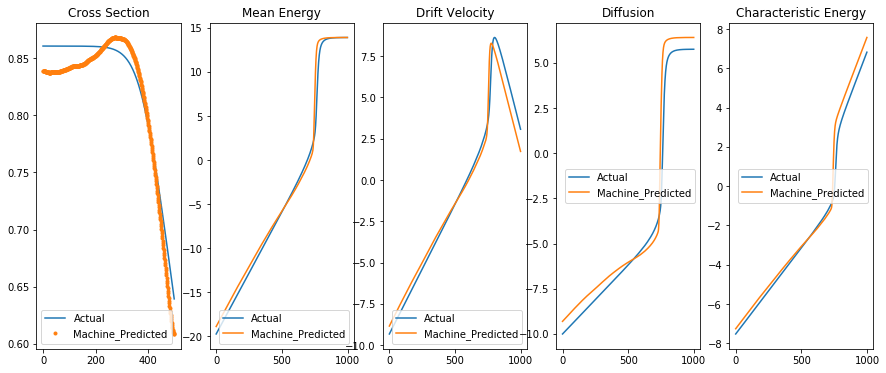

|(1000, 4)


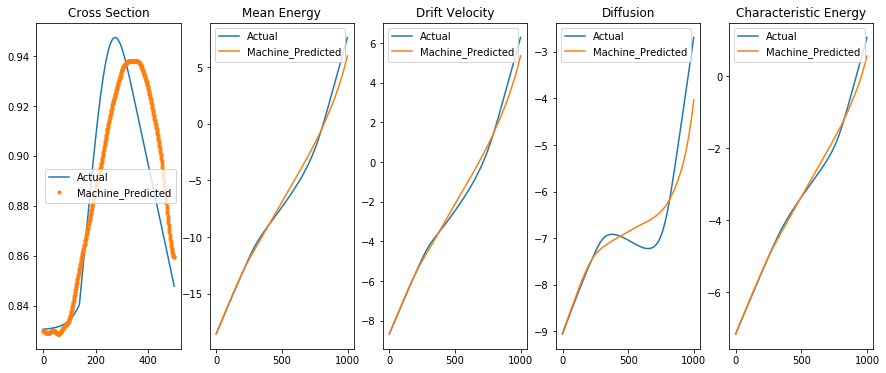

|(1000, 4)


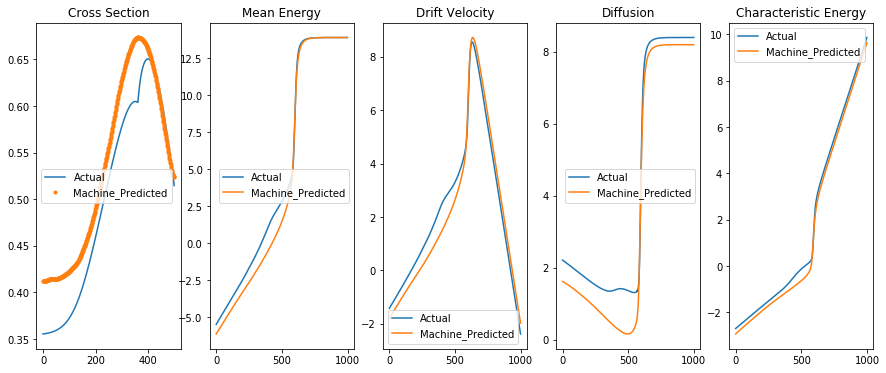

|(1000, 4)


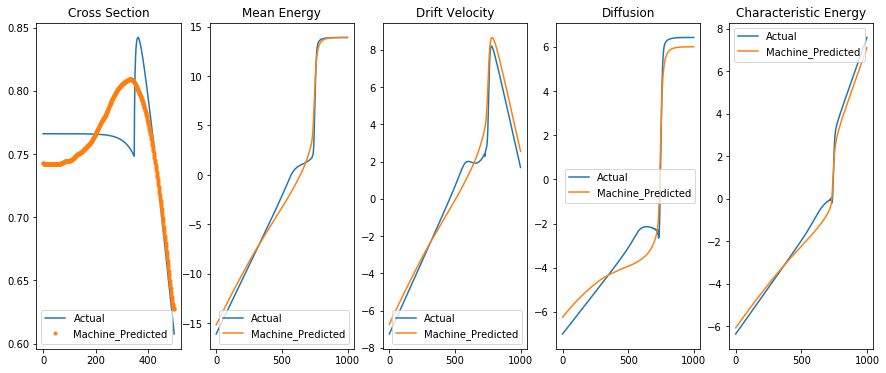

|(1000, 4)


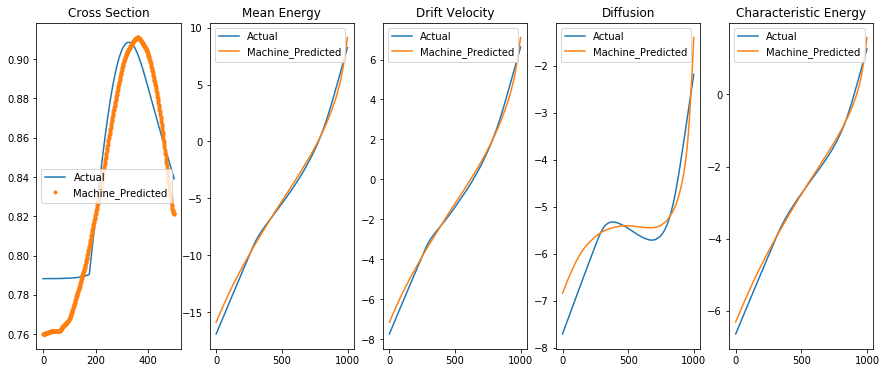

|(1000, 4)


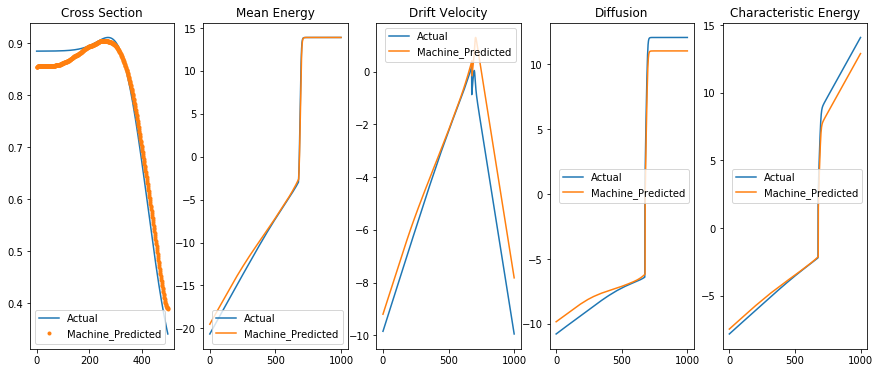

|(1000, 4)


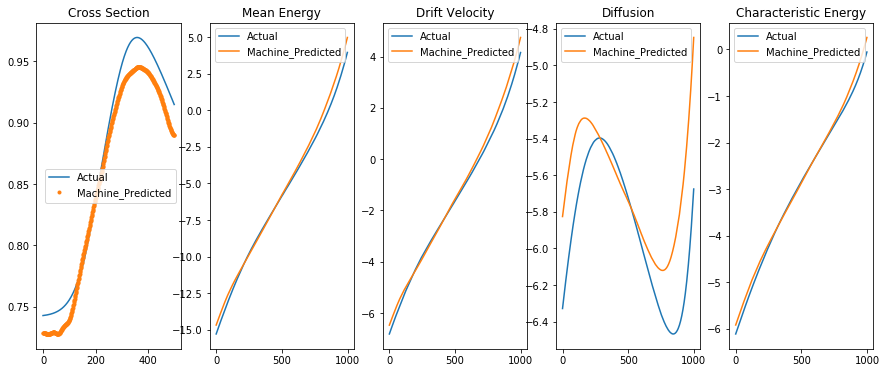

|(1000, 4)


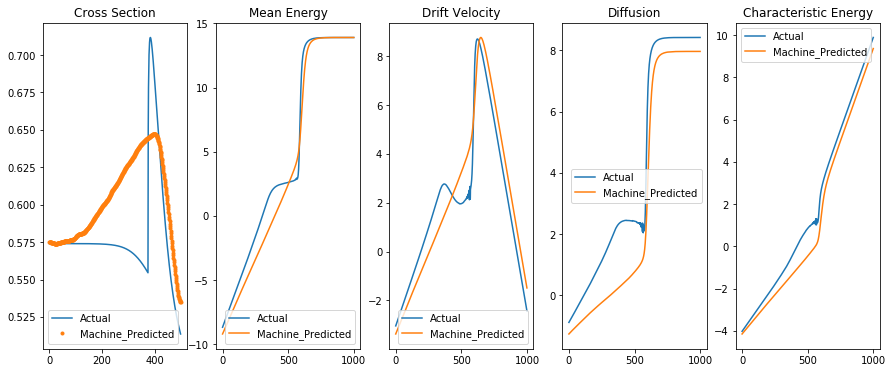

|(1000, 4)


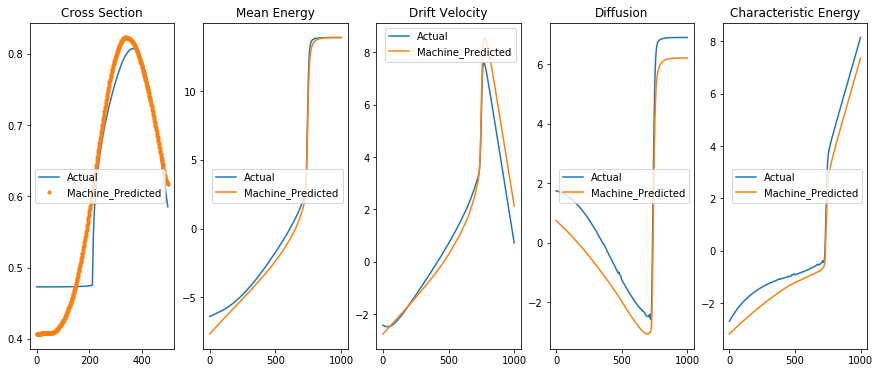

|(1000, 4)


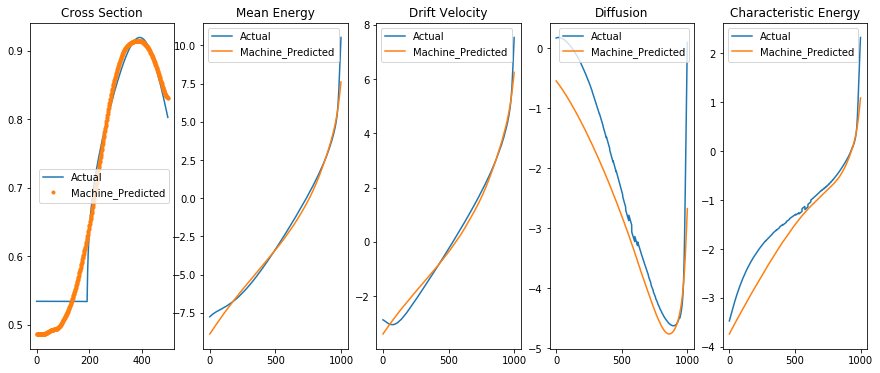

|(1000, 4)


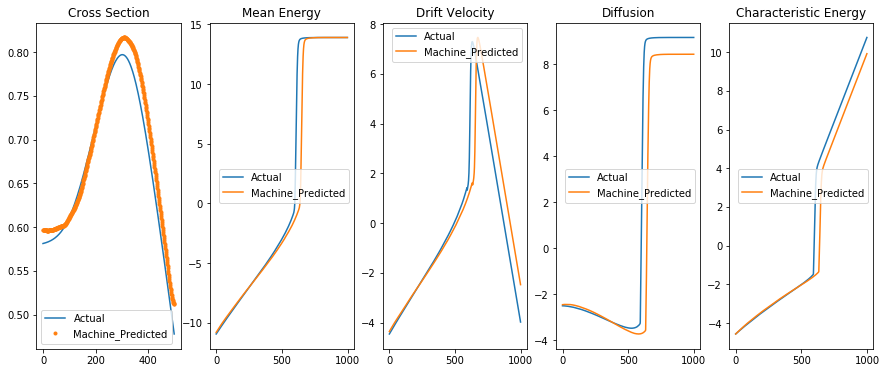

|(1000, 4)


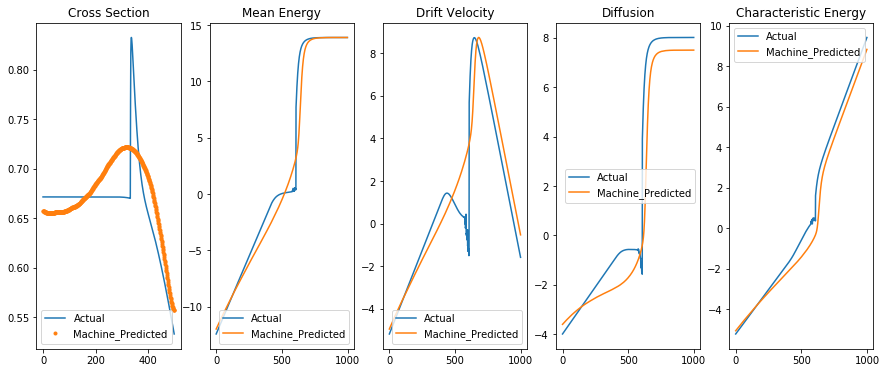

|(1000, 4)


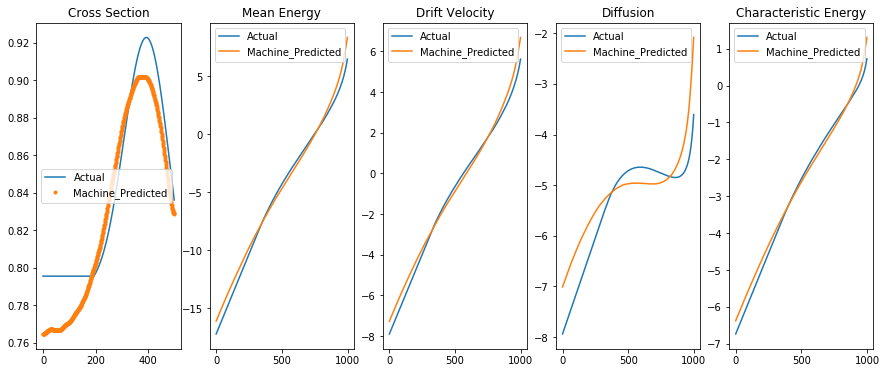

|(1000, 4)


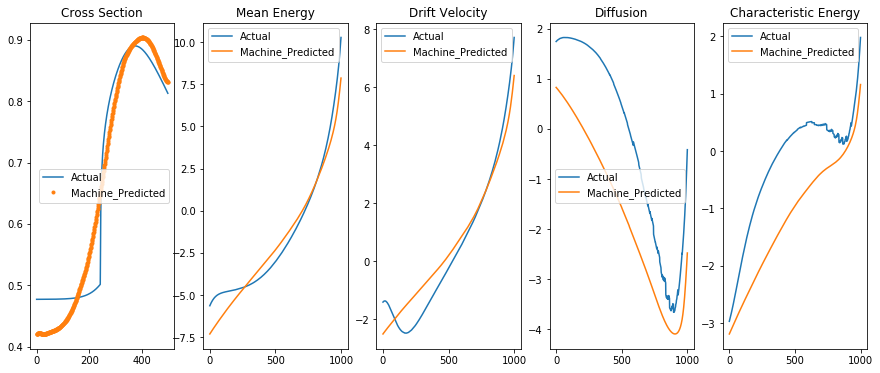

|(1000, 4)


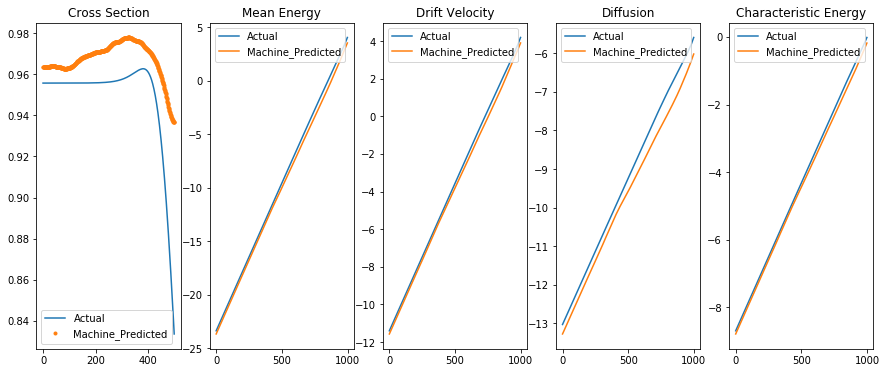

|(1000, 4)


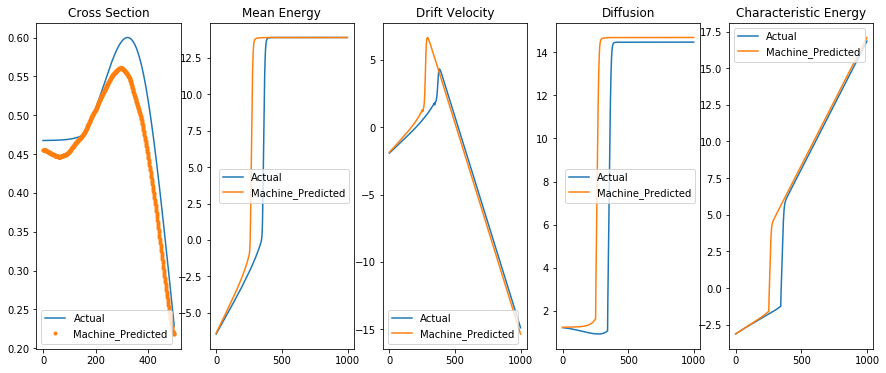

|(1000, 4)


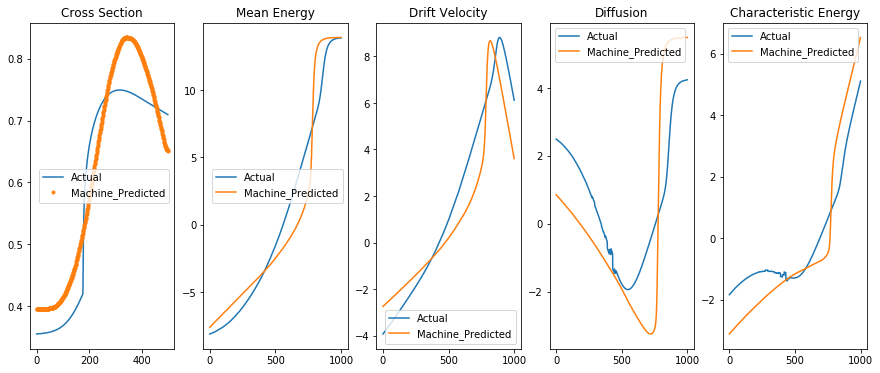

|(1000, 4)


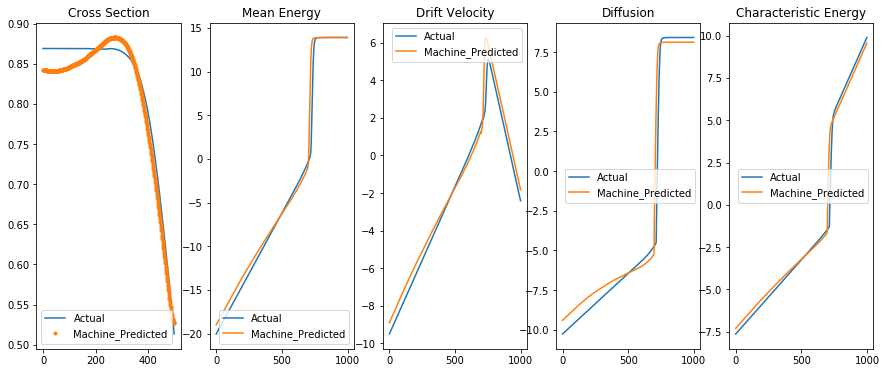

|(1000, 4)


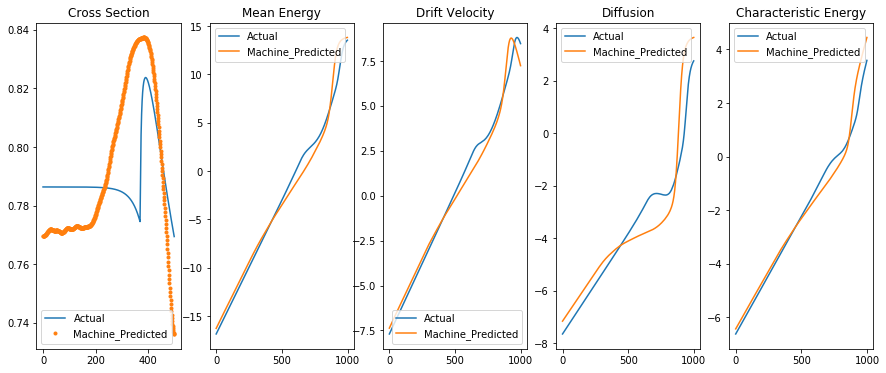

|(1000, 4)


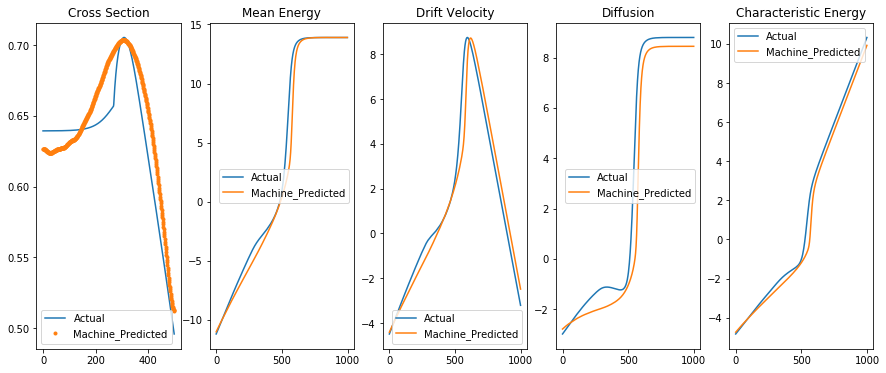

|(1000, 4)


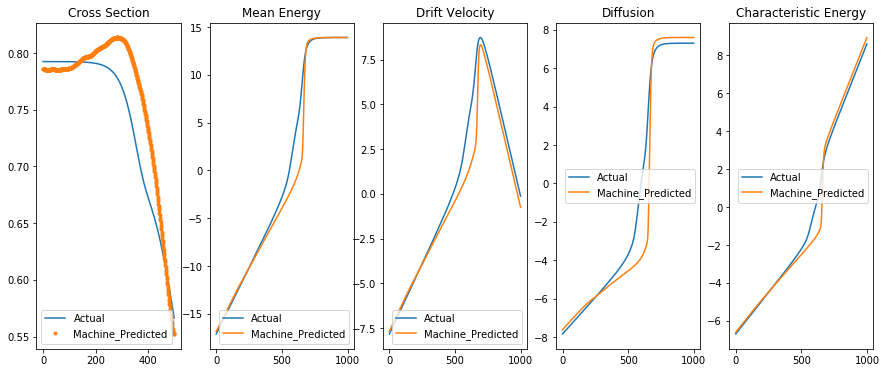

|(1000, 4)


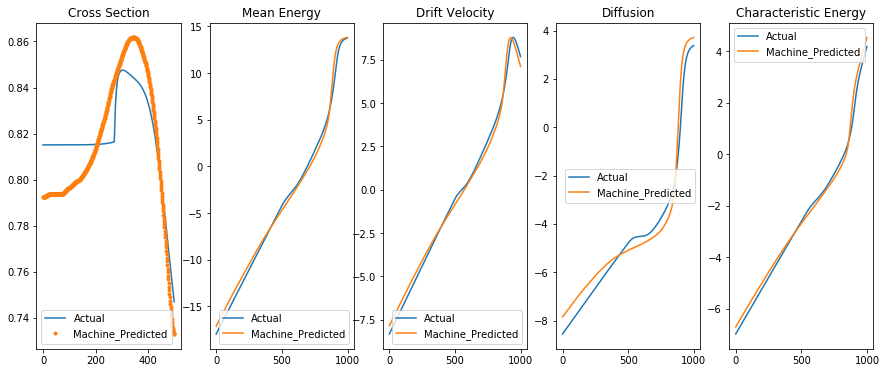

|(1000, 4)


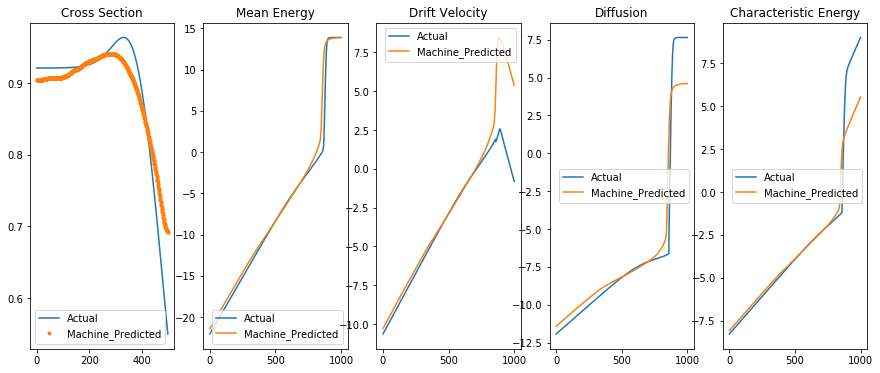

|(1000, 4)


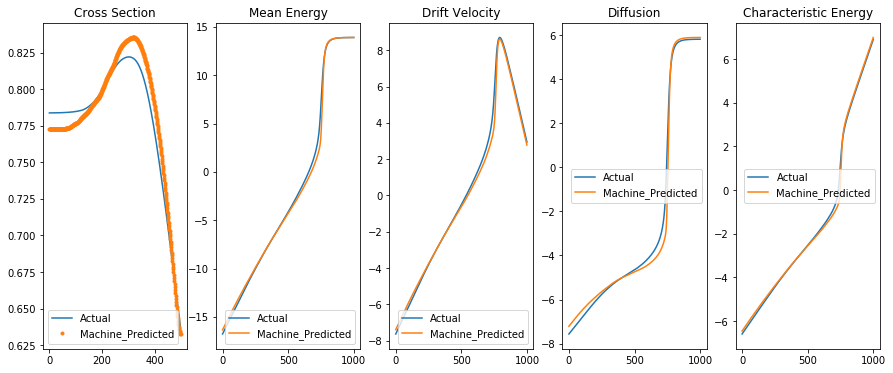

|(1000, 4)


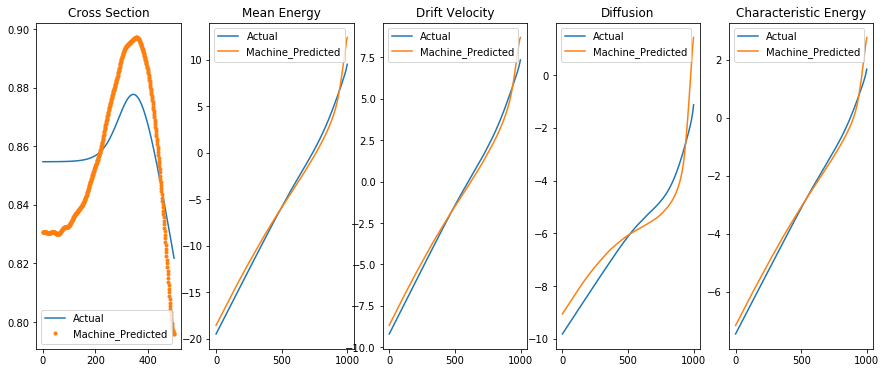

|(1000, 4)


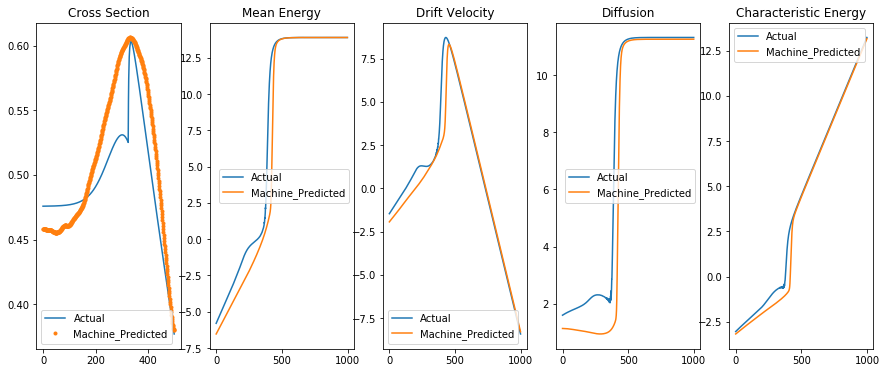

|(1000, 4)


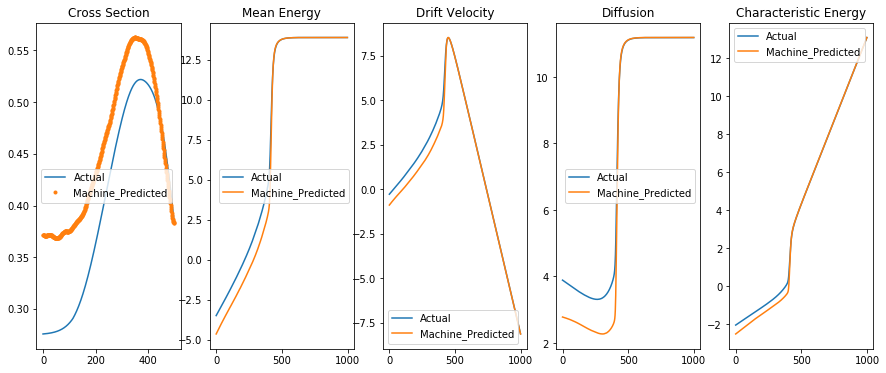

|(1000, 4)


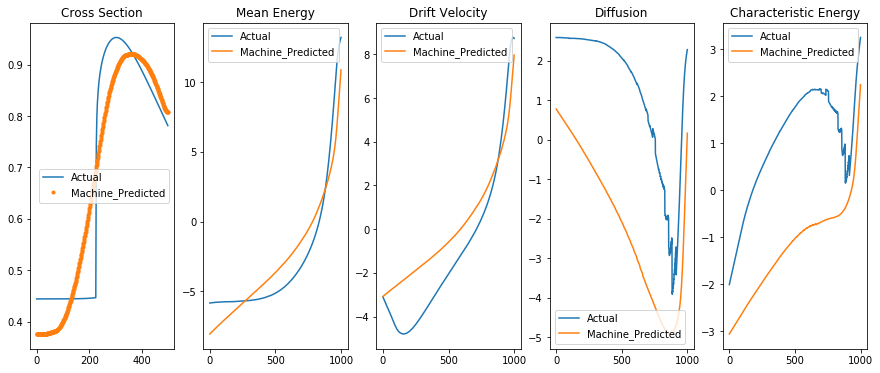

|(1000, 4)


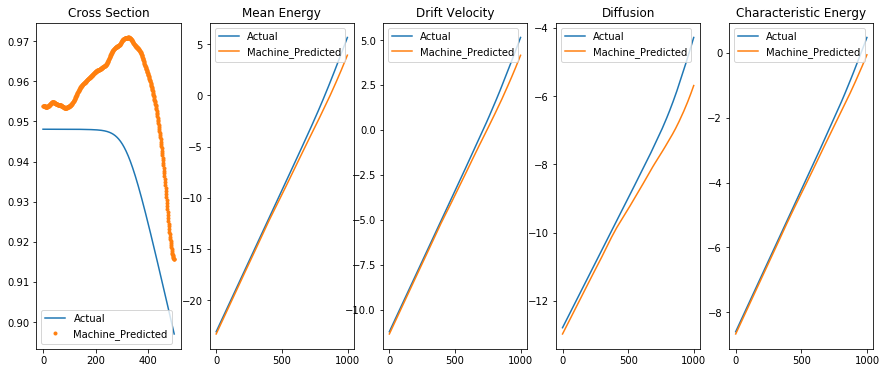

|(1000, 4)


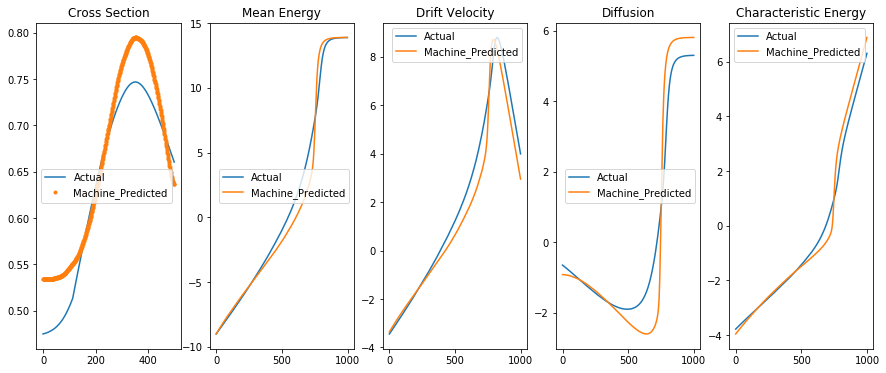

|(1000, 4)


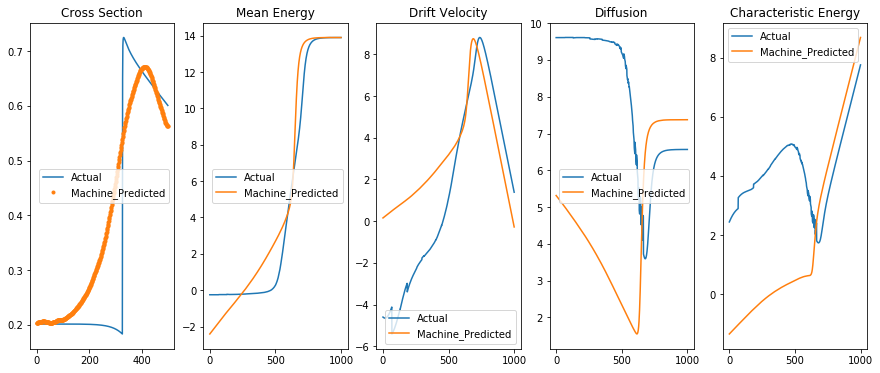

|(1000, 4)


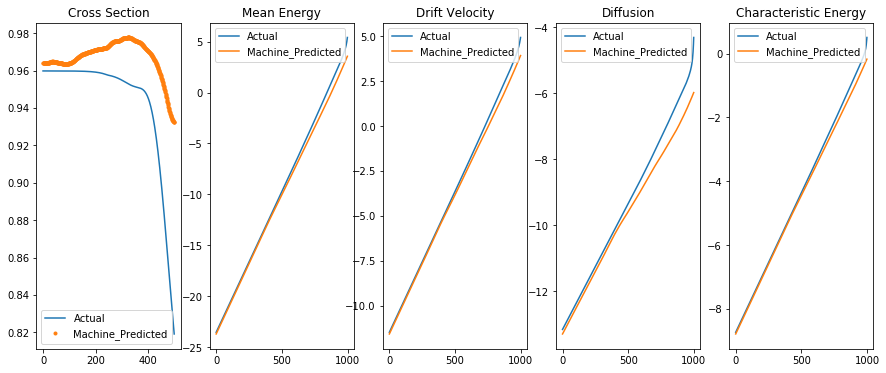

|(1000, 4)


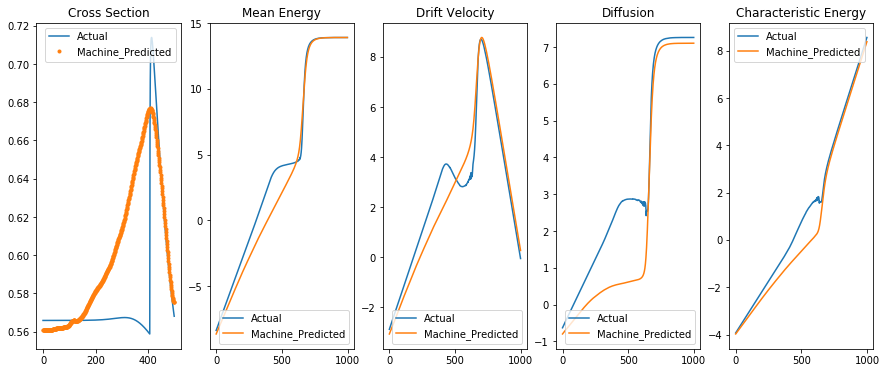

|(1000, 4)


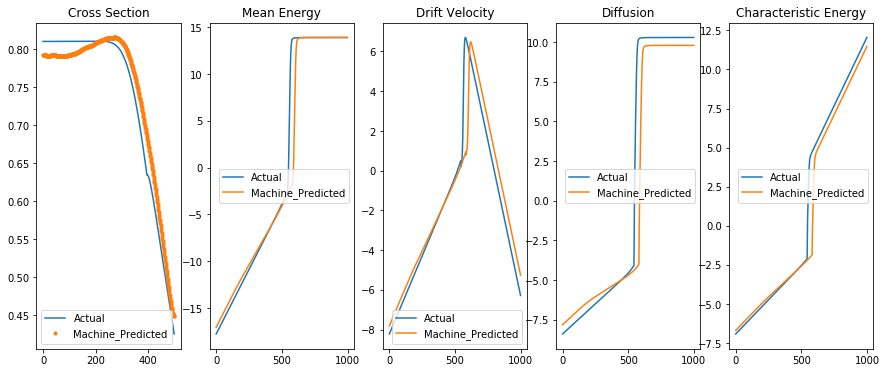

|(1000, 4)


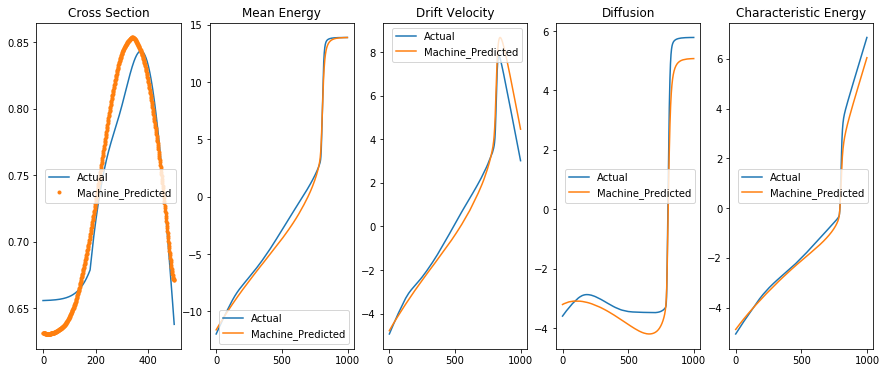

|(1000, 4)


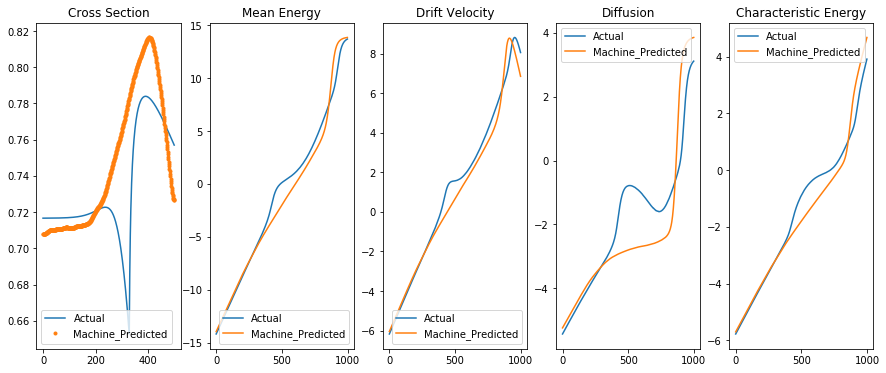

|(1000, 4)


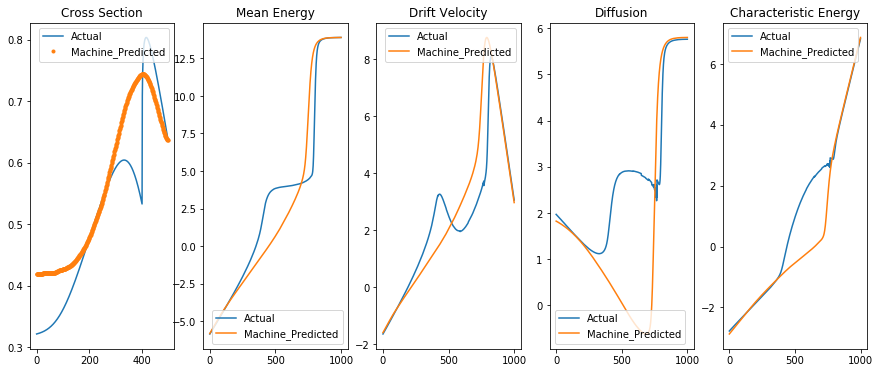

|(1000, 4)


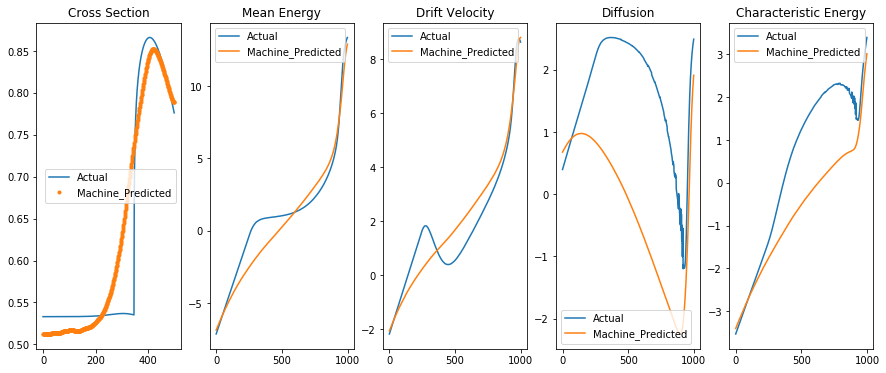

|(1000, 4)


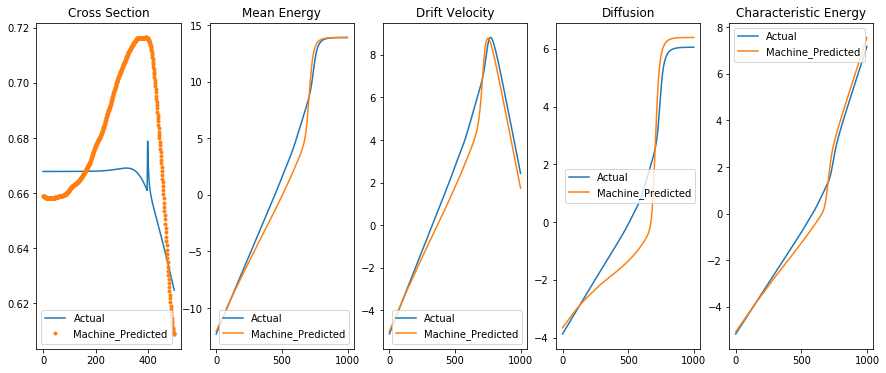

|(1000, 4)


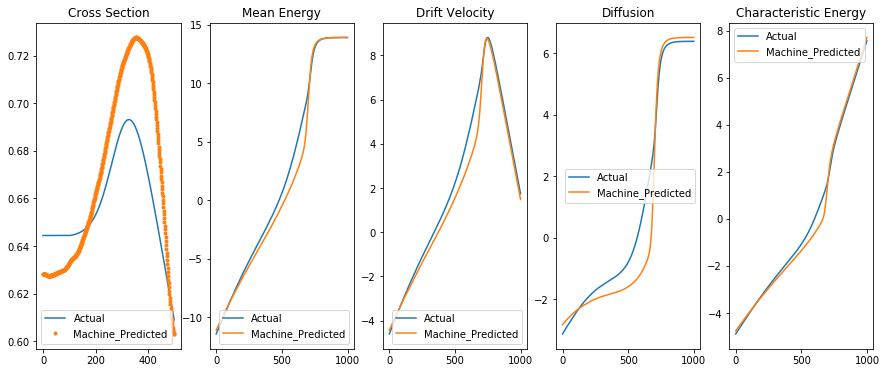

|(1000, 4)


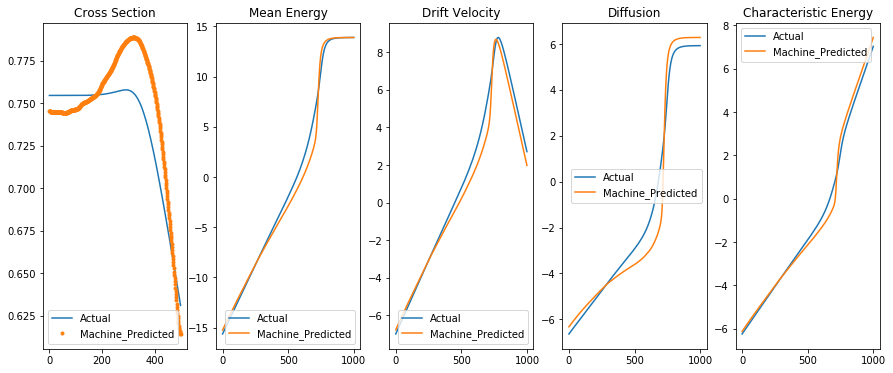

|(1000, 4)


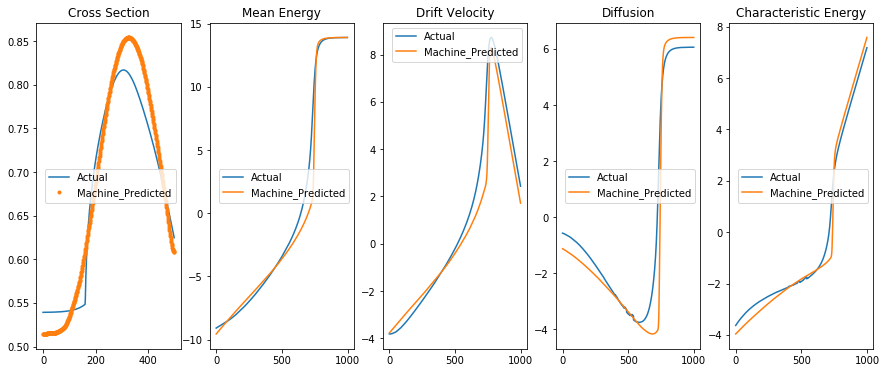

285.3124215602875


In [54]:
import importlib
import bolsig
importlib.reload(bolsig)
from bolsig import bolsig
print(dir(bolsig))

n=100

pdf=y_hat[:n,:]
    
#Inverting normalisation on Y
pdf=10**((pdf*y_max)+y_min)*1e-20

E=np.logspace(-3,3,500)

t=time.time()
for i in range(n):
    bolsig.Input(E,pdf[i,:])
    bolsig.ex(grid=100,n=1000) #n cannot be more than 1000
    bolsig.Bolsig()
    trans=bolsig.Output(n=1000)
    print('|',end='')
    if np.sum(trans<0)>0:
        plt.loglog(E,Y[i,:]*1e20)
        plt.show()
        continue
    print(np.shape(trans))
    trans=np.log10(trans)
    #Normalisation trans to match X
    trans=np.reshape(trans,(-1,1000,4))
    for j in range(4):
        trans[:,:,j]=(trans[:,:,j]-x_mean[j])/x_std[j]
    
    fig, ax = plt.subplots(1, 5, figsize=(15,6))
    title=['Cross Section','Mean Energy','Drift Velocity','Diffusion','Characteristic Energy']
    ax[0].plot(y_train[i,:])
    ax[0].plot(y_hat[i,:],'.')
    ax[0].legend(['Actual','Machine_Predicted'])
    ax[0].set_title(title[0])
    for j in range(4):
        ax[j+1].plot(np.reshape(x_train[i,:],(1000,4))[:,j])
        ax[j+1].plot(trans[0,:,j])
        ax[j+1].legend(['Actual','Machine_Predicted'])
        ax[j+1].set_title(title[j+1])
    plt.savefig(str(i)+'.png')
    plt.show()
print(time.time()-t)